In [1]:
import numpy as np
from scipy.signal import butter, filtfilt, welch, find_peaks
from itertools import groupby
import pandas as pd

class UnifiedSignalSQA:
    def __init__(self, signal, fs, signal_type):
        """
        Unified Signal Quality Assessment for ECG or PCG.

        Args:
            signal (np.array): 1D signal data (ECG or PCG)
            fs (int): Sampling frequency in Hz
            signal_type (str): 'ecg' or 'pcg'
        """
        self.signal = signal
        self.fs = fs
        self.N = len(signal)
        self.signal_type = signal_type.lower()

    #########################
    # COMMON FUNCTIONS
    #########################

    def _detect_flatline(self, std_thresh, range_thresh, diff_thresh, peak_height, window_sec=2.0, step_sec=1.0):
        win = int(window_sec * self.fs)
        step = int(step_sec * self.fs)
        segments = []

        for i in range(0, self.N - win + 1, step):
            seg = self.signal[i:i+win]
            std = np.std(seg)
            rng = np.ptp(seg)
            mean_diff = np.mean(np.abs(np.diff(seg)))
            peaks, _ = find_peaks(seg, height=peak_height)

            if std < std_thresh and rng < range_thresh and mean_diff < diff_thresh and len(peaks) == 0:
                t1 = i / self.fs
                t2 = (i + win) / self.fs
                segments.append((t1, t2))
        return segments

    def _compute_hf_noise(self, hf_band, window_sec=5.0, min_ratio=0.1):
        win = int(window_sec * self.fs)
        step = win // 2
        segments = [self.signal[i:i + win] for i in range(0, self.N - win + 1, step)]

        ratios = []
        for seg in segments:
            f, psd = welch(seg, fs=self.fs, nperseg=1024)
            total = np.sum(psd)
            hf = np.sum(psd[(f > hf_band[0]) & (f < hf_band[1])])
            ratios.append(hf / total if total > 0 else 0)

        ratios = np.array(ratios)
        threshold = max(min_ratio, np.percentile(ratios, 80))
        noisy_flags = ratios > threshold
        max_streak = max((sum(1 for _ in g) for k, g in groupby(noisy_flags) if k), default=0)

        return {
            "prob_noisy": np.mean(noisy_flags),
            "avg_hf_ratio": np.mean(ratios[noisy_flags]) if np.any(noisy_flags) else 0,
            "adaptive_threshold": threshold,
            "max_noisy_streak": max_streak
        }

    #########################
    # ECG-SPECIFIC METHODS
    #########################

    def _remove_baseline(self, cutoff=1.0):
        freq = np.fft.fftfreq(self.N, 1 / self.fs)
        X = np.fft.fft(self.signal)
        X[np.abs(freq) < cutoff] = 0
        return np.fft.ifft(X).real

    def _detect_ecg_baseline_wander(self, cutoff=1.0, bw_thresh=0.1, abw_thresh=0.2):
        baseline_removed = self._remove_baseline(cutoff)
        residual = self.signal - baseline_removed
        bw_present = np.max(np.abs(residual)) > bw_thresh

        P = int(0.5 * self.fs)
        Q = int(0.25 * self.fs)
        peaks = [np.max(np.abs(residual[start:start + P]))
                 for start in range(0, self.N - P + 1, Q)]

        diffs = np.diff(peaks)
        abw_detected = np.max(np.abs(diffs)) > abw_thresh
        return {"bw_present": bw_present, "abw_detected": abw_detected}

    #########################
    # PCG-SPECIFIC METHODS
    #########################

    def _detect_pcg_clipping(self, clip_thresh=0.95):
        max_val = np.max(np.abs(self.signal))
        return max_val > clip_thresh

    def _estimate_pcg_snr(self, bandpass=(20, 150)):
        b, a = butter(4, [bandpass[0] / (self.fs / 2), bandpass[1] / (self.fs / 2)], btype='band')
        filtered = filtfilt(b, a, self.signal)
        power_total = np.mean(self.signal ** 2)
        power_band = np.mean(filtered ** 2)
        snr = 10 * np.log10(power_band / (power_total - power_band + 1e-12))
        return snr

    #########################
    # MAIN ANALYSIS ENTRY
    #########################

    def analyze(self):
        if self.signal_type == 'ecg':
            return {
                "signal_type": "ecg",
                "baseline": self._detect_ecg_baseline_wander(),
                "flatline_segments": self._detect_flatline(
                    std_thresh=0.01, range_thresh=0.005,
                    diff_thresh=0.01, peak_height=0.05),
                "hf_noise": self._compute_hf_noise(hf_band=(45, 100))
            }

        elif self.signal_type == 'pcg':
            return {
                "signal_type": "pcg",
                "flatline_segments": self._detect_flatline(
                    std_thresh=0.01, range_thresh=0.005,
                    diff_thresh=0.001, peak_height=0.05),
                "hf_noise": self._compute_hf_noise(hf_band=(500, 1500)),
                "clipping_detected": self._detect_pcg_clipping(),
                "snr_db": self._estimate_pcg_snr()
            }

        else:
            raise ValueError(f"Unsupported signal type: {self.signal_type}")


In [2]:
import pandas as pd
df = pd.read_csv(r'/home/psyche/Documents/ProJect64/ProJect64 System Architect/Data/Synched_Data/2_14-31-23_synced.csv')
ecg_array = df['ECG'].values
pcg_array = df['PCG'].values
# For ECG
sqa_ecg = UnifiedSignalSQA(ecg_array, fs=500, signal_type='ecg')
result_ecg = sqa_ecg.analyze()

# For PCG
sqa_pcg = UnifiedSignalSQA(pcg_array, fs=1000, signal_type='pcg')
result_pcg = sqa_pcg.analyze()

print(result_ecg)
print(result_pcg)


{'signal_type': 'ecg', 'baseline': {'bw_present': np.True_, 'abw_detected': np.True_}, 'flatline_segments': [], 'hf_noise': {'prob_noisy': np.float64(0.0), 'avg_hf_ratio': 0, 'adaptive_threshold': 0.1, 'max_noisy_streak': 0}}
{'signal_type': 'pcg', 'flatline_segments': [], 'hf_noise': {'prob_noisy': np.float64(0.0), 'avg_hf_ratio': 0, 'adaptive_threshold': 0.1, 'max_noisy_streak': 0}, 'clipping_detected': np.True_, 'snr_db': np.float64(9.783125739001623)}


In [3]:
# -*- coding: utf-8 -*-
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import scipy.signal as signal
import yaml

class ECGfilter(BaseEstimator, TransformerMixin):
    """SQA-aware ECG filtering pipeline."""
    def __init__(self, fs=500, lowcut=0.5, highcut=45, order=4,
                 config=None, config_path=None, sqa_result=None):
        self.fs = fs
        self.lowcut = lowcut
        self.highcut = highcut
        self.order = order
        self.config = config or {}
        self.config_path = config_path
        self.sqa_result = sqa_result  # Injected externally

        if self.config_path:
            try:
                with open(self.config_path, 'r') as file:
                    self.config = yaml.safe_load(file)
            except Exception as e:
                print(f"Error loading config file: {e}")
                self.config = {}
        elif not self.config:
            print("Config not provided. Using default values.")
            self.config = {
                "ecg_filter_config": {
                    "powerline_interference_frequency": 50,
                    "notch_filter_quality_factor": 30
                }
            }

    def set_sqa_result(self, sqa_result):
        """Optional setter for injecting SQA analysis externally."""
        self.sqa_result = sqa_result

    @staticmethod
    def remove_baseline_wander(raw_signal, fs, cutoff=0.5, order=2):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
        return signal.filtfilt(b, a, raw_signal)

    @staticmethod
    def remove_powerline_interference(raw_signal, fs, notch_freq=50, quality_factor=30):
        nyq = 0.5 * fs
        w0 = notch_freq / nyq
        b, a = signal.iirnotch(w0, quality_factor)
        return signal.filtfilt(b, a, raw_signal)

    @staticmethod
    def remove_muscle_artifacts_and_electrode_motion(raw_signal, fs, low_cut=0.5, high_cut=45, order=4):
        nyq = 0.5 * fs
        low = low_cut / nyq
        high = high_cut / nyq
        b, a = signal.butter(order, [low, high], btype='band')
        return signal.filtfilt(b, a, raw_signal)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Apply filters based on SQA results.
        """
        if self.sqa_result is None:
            raise ValueError("SQA result not set. Use `.set_sqa_result()` or pass in constructor.")

        # STEP 1: Baseline Wander Removal
        if self.sqa_result.get("baseline", {}).get("bw_present", False):
            X = self.remove_baseline_wander(X, self.fs, cutoff=self.lowcut, order=self.order)

        # STEP 2: Powerline Interference
        notch_freq = self.config["ecg_filter_config"].get("powerline_interference_frequency", 50)
        q_factor = self.config["ecg_filter_config"].get("notch_filter_quality_factor", 30)

        if self.sqa_result.get("hf_noise", {}).get("avg_hf_ratio", 0) > 0.1:
            X = self.remove_powerline_interference(X, self.fs, notch_freq, q_factor)

        # STEP 3: Muscle/Electrode Artifacts
        if self.sqa_result.get("hf_noise", {}).get("prob_noisy", 0) > 0.3:
            X = self.remove_muscle_artifacts_and_electrode_motion(X, self.fs,
                                                                   low_cut=self.lowcut,
                                                                   high_cut=self.highcut,
                                                                   order=self.order)

        return X


In [4]:
zonfig_path = '/home/psyche/Documents/ProJect64/ProJect64 System Architect/src/config/meta_ecg.yaml'

# Step 2: Apply filtering with SQA-guided logic
filt = ECGfilter(fs=500, config_path=zonfig_path)
filt.set_sqa_result(result_ecg)
filtered_signal = filt.transform(ecg_array)


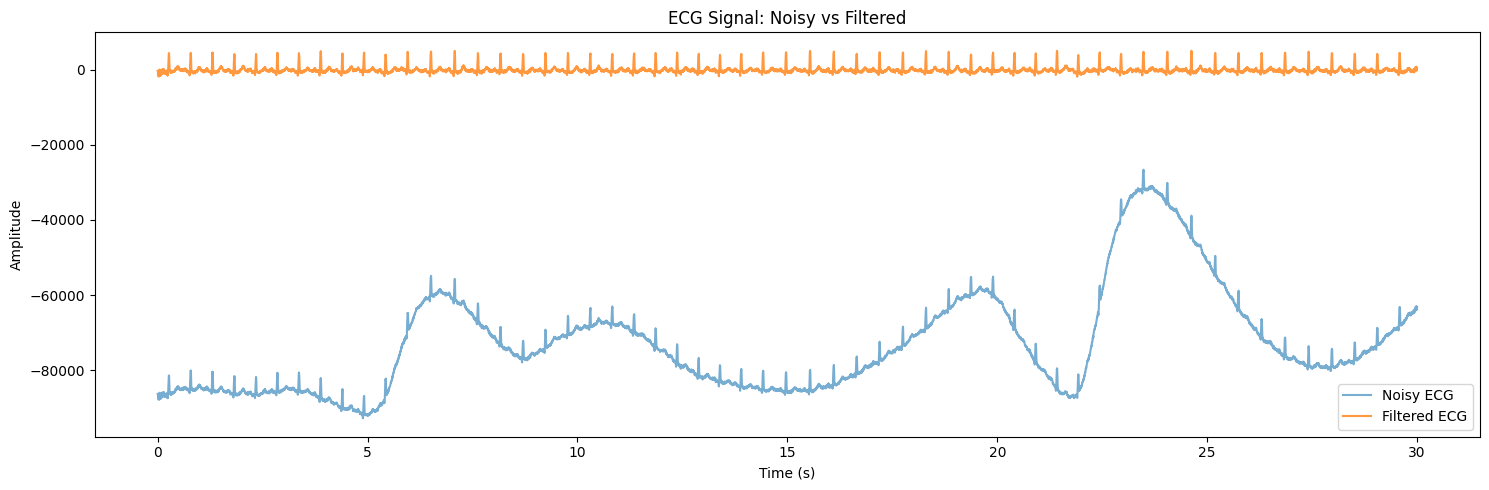

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df['Time'], ecg_array, label='Noisy ECG', alpha=0.6)
plt.plot(df['Time'], filtered_signal, label='Filtered ECG', alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG Signal: Noisy vs Filtered')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.signal as sig
import yaml
import numpy as np

class PCGfilter(BaseEstimator, TransformerMixin):
    """SQA-aware PCG filtering pipeline."""
    def __init__(self, fs, lowcut=20, highcut=400, order=4, config_path=None, sqa_result=None):
        self.fs = fs
        self.lowcut = lowcut
        self.highcut = highcut
        self.order = order
        self.config_path = config_path
        self.sqa_result = sqa_result

        if self.config_path:
            try:
                with open(self.config_path, 'r') as file:
                    self.config = yaml.safe_load(file)
            except Exception as e:
                print(f"Error loading config file: {e}")
                self.config = {}
        else:
            print("Config path not provided. Using default parameters.")
            self.config = {
                "pcg_filter_config": {
                    "snr_threshold": 5.0,
                    "hf_noise_threshold": 0.4,
                    "clipping_threshold": 0.95
                }
            }

    def set_sqa_result(self, sqa_result):
        """Setter to inject SQA results."""
        self.sqa_result = sqa_result

    def bandpass(self, signal, filter_type='butter'):
        nyquist = 0.5 * self.fs
        low = self.lowcut / nyquist
        high = self.highcut / nyquist
        sos = sig.butter(self.order, [low, high], btype='bandpass', output='sos')
        return sig.sosfiltfilt(sos, signal)

    def clip_protection(self, signal):
        """Apply simple clipping protection by soft normalization."""
        max_val = np.max(np.abs(signal))
        if max_val > 1.0:
            signal = signal / max_val
        return signal

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Apply filtering conditionally based on SQA findings.
        """
        if self.sqa_result is None:
            raise ValueError("SQA result not set. Use `.set_sqa_result()` or pass in constructor.")

        snr_thresh = self.config["pcg_filter_config"].get("snr_threshold", 5.0)
        hf_noise_thresh = self.config["pcg_filter_config"].get("hf_noise_threshold", 0.4)

        # STEP 1: Skip or flag flatlines
        flat_segs = self.sqa_result.get("flatline_segments", [])
        if len(flat_segs) > 0:
            print("Warning: Flatline segments detected. Consider masking these regions.")
            # Optional: replace flatline regions or mark them

        # STEP 2: Clipping check
        if self.sqa_result.get("clipping_detected", False):
            print("Warning: Amplitude clipping detected. Applying normalization.")
            X = self.clip_protection(X)

        # STEP 3: Apply bandpass filtering only if SNR is low or HF noise is high
        snr_db = self.sqa_result.get("snr_db", 10.0)
        prob_noisy = self.sqa_result.get("hf_noise", {}).get("prob_noisy", 0.0)

        if snr_db < snr_thresh or prob_noisy > hf_noise_thresh:
            X = self.bandpass(X)
        else:
            print("PCG signal quality good — skipping aggressive filtering.")

        return X


In [7]:
# Step 1: Run SQA on PCG


# Step 2: Apply SQA-aware filtering
filt = PCGfilter(fs=1000)
filt.set_sqa_result(result_pcg)
filtered_pcg = filt.transform(pcg_array)


Config path not provided. Using default parameters.
PCG signal quality good — skipping aggressive filtering.


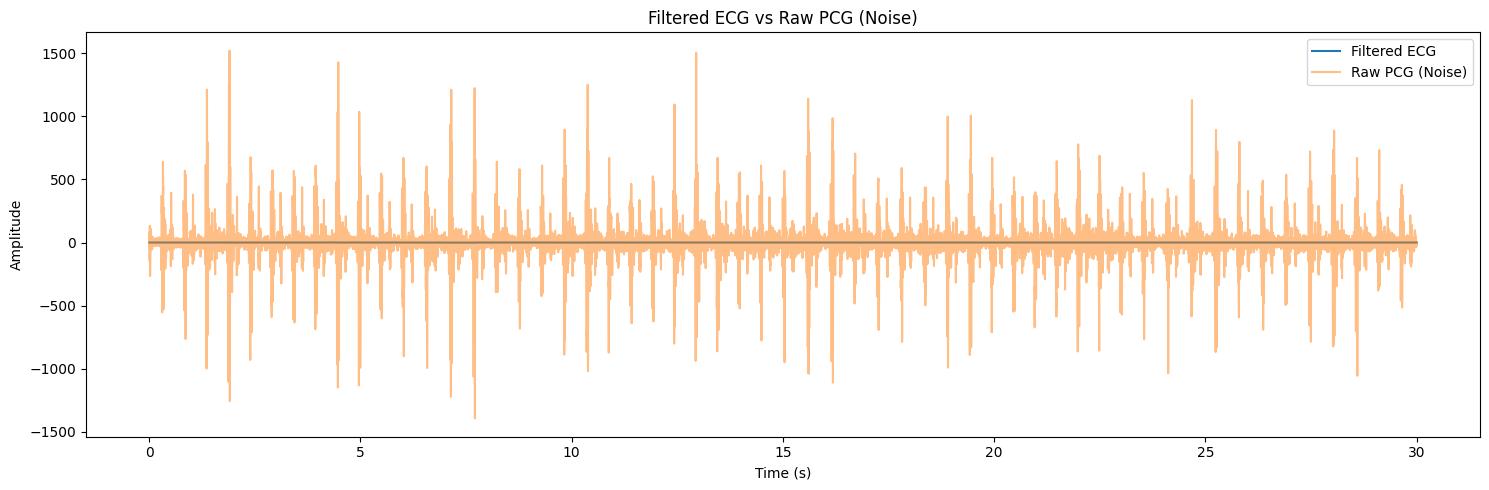

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], filtered_pcg , label='Filtered ECG', alpha=1
         )
plt.plot(df['Time'], pcg_array, label='Raw PCG (Noise)', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered ECG vs Raw PCG (Noise)')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
sqa_ecg = UnifiedSignalSQA(filtered_signal, fs=500, signal_type='ecg')
result1_ecg = sqa_ecg.analyze()

# For PCG
sqa_pcg = UnifiedSignalSQA(filtered_pcg, fs=1000, signal_type='pcg')
result1_pcg = sqa_pcg.analyze()

print(result1_ecg)
print(result1_pcg)


{'signal_type': 'ecg', 'baseline': {'bw_present': np.True_, 'abw_detected': np.True_}, 'flatline_segments': [], 'hf_noise': {'prob_noisy': np.float64(0.0), 'avg_hf_ratio': 0, 'adaptive_threshold': 0.1, 'max_noisy_streak': 0}}
{'signal_type': 'pcg', 'flatline_segments': [], 'hf_noise': {'prob_noisy': np.float64(0.0), 'avg_hf_ratio': 0, 'adaptive_threshold': 0.1, 'max_noisy_streak': 0}, 'clipping_detected': np.True_, 'snr_db': np.float64(9.783125734974622)}


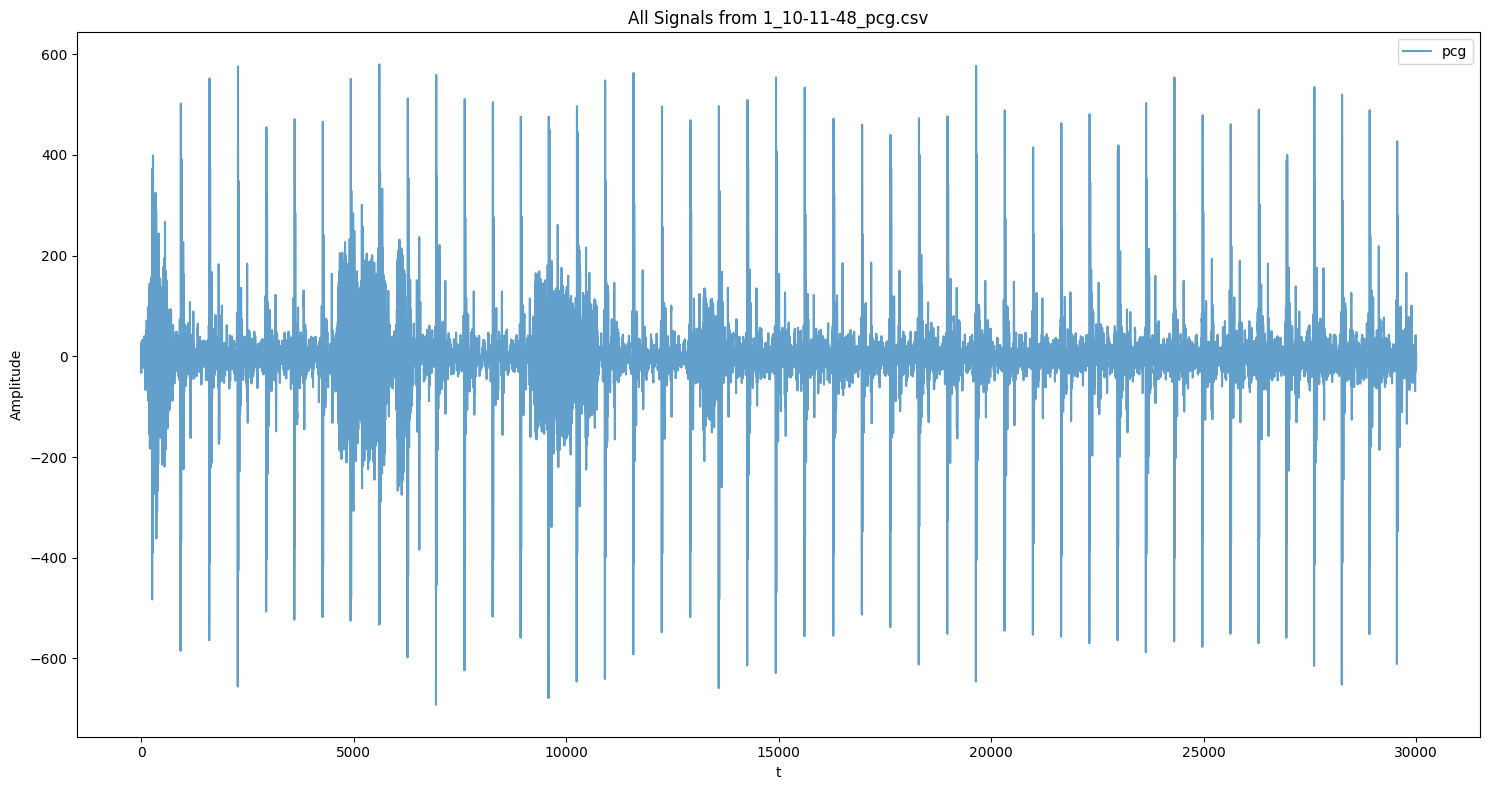

In [4]:
df_pcg = pd.read_csv('/home/psyche/Documents/ProJect64/ProJect64 System Architect/Data/Rel_Data/1_10-11-48_pcg.csv')

plt.figure(figsize=(15, 8))
for col in df_pcg.columns:
    if col.lower() != 't' and col.lower() != 'time':
        plt.plot(df_pcg[df_pcg.columns[0]], df_pcg[col], label=col, alpha=0.7)

plt.xlabel(df_pcg.columns[0])
plt.ylabel('Amplitude')
plt.title('All Signals from 1_10-11-48_pcg.csv')
plt.legend()
plt.tight_layout()
plt.show()


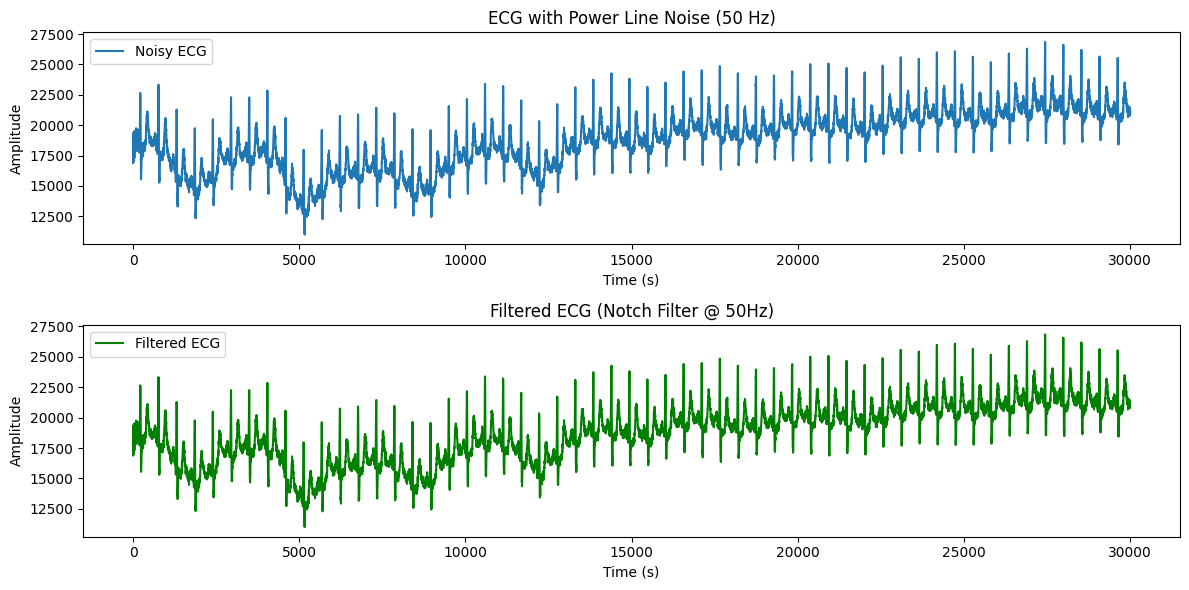

In [20]:

from scipy.signal import iirnotch, filtfilt
from matplotlib import pyplot as plt

def apply_notch_filter(ecg_signal, fs, notch_freq=50.0, quality_factor=30.0):
    """
    Applies a notch filter to remove power line interference (e.g., 50Hz or 60Hz).
    
    Parameters:
        ecg_signal (np.ndarray): The raw ECG signal.
        fs (float): Sampling frequency in Hz.
        notch_freq (float): Frequency to be removed (typically 50 or 60 Hz).
        quality_factor (float): The quality factor of the notch filter (higher = narrower).
    
    Returns:
        np.ndarray: Filtered ECG signal.
    """
    b, a = iirnotch(notch_freq, quality_factor, fs)
    filtered_ecg = filtfilt(b, a, ecg_signal)
    return filtered_ecg

# === Example usage ===

# Simulated noisy ECG signal
fs = 500  # sampling rate in Hz
t = np.linspace(0, 10, fs * 10)  # 10 seconds
pure_ecg = 1.0 * np.sin(2 * np.pi * 1 * t)  # simulate a clean ECG (1 Hz sine wave)
power_noise = 0.2 * np.sin(2 * np.pi * 50 * t)  # 50 Hz noise
noisy_ecg_path  = "/home/psyche/Documents/ProJect64/ProJect64 System Architect/Data/Synched_Data/1_10-29-01_synced.csv"

import pandas as pd
df_noisy = pd.read_csv(noisy_ecg_path)
noisy_ecg = df_noisy['ECG'].values  # Assuming the ECG data
# Filter the signal
filtered_ecg = apply_notch_filter(noisy_ecg, fs, notch_freq=60)

# === Plot ===
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(noisy_ecg, label="Noisy ECG")
plt.title("ECG with Power Line Noise (50 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2,1,2)
plt.plot( filtered_ecg, label="Filtered ECG", color='green')
plt.title("Filtered ECG (Notch Filter @ 50Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
import sys
import os
sys.path.append(os.path.abspath("../../"))  # Adjust path as needed to reach your project root

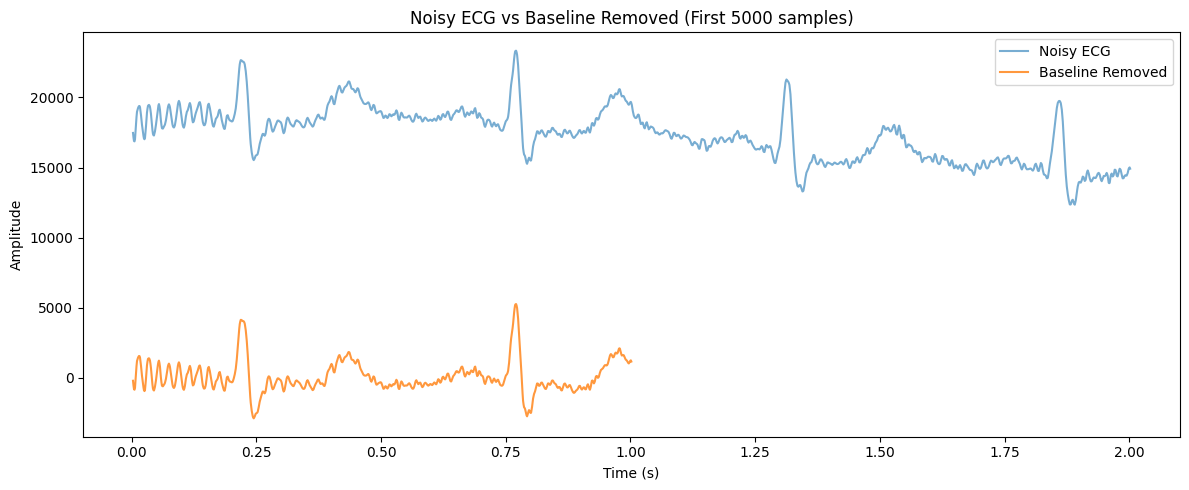

In [25]:
# Remove baseline wander from noisy_ecg using ECGfilter static method
from src.signal_preprocessing.ecg_noise_control import ECGfilter

baseline_removed = ECGfilter.remove_baseline_wander(noisy_ecg, fs, cutoff=1.5, order=5)

# Plot the first 5000 samples
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_noisy['Time'][:2000], noisy_ecg[:2000], label='Noisy ECG', alpha=0.6)
plt.plot(df_noisy['Time'][:1000], baseline_removed[:1000], label='Baseline Removed', alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noisy ECG vs Baseline Removed (First 5000 samples)')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd
import os
import shutil

# === CONFIGURE THIS ===
csv_path = "/home/psyche/Downloads/Online_Appendix_training_set.csv"  # CHANGE this to your CSV path
physionet_dir = "/home/psyche/Downloads/archive (2)"  # CHANGE this to your folder
normal_dir = os.path.join(physionet_dir, "normal")
abnormal_dir = os.path.join(physionet_dir, "abnormal")

# === Create destination folders ===
os.makedirs(normal_dir, exist_ok=True)
os.makedirs(abnormal_dir, exist_ok=True)

# === Load CSV ===
df = pd.read_csv(csv_path)

# Normalize column names (in case they have spaces)
df.columns = [col.strip().lower() for col in df.columns]

# Map of class to destination
label_to_folder = {
    "normal": normal_dir,
    "abnormal": abnormal_dir
}

# === Iterate and move files ===
for _, row in df.iterrows():
    patient_id = row["patient_id"]
    label = row["class"].lower()

    src_base = os.path.join(physionet_dir, patient_id)

    # Move .wav and .hea files if they exist
    for ext in [".wav", ".hea"]:
        src_file = src_base + ext
        if os.path.exists(src_file):
            dst_file = os.path.join(label_to_folder[label], patient_id + ext)
            shutil.copy2(src_file, dst_file)
            print(f"Moved {src_file} -> {dst_file}")
        else:
            print(f"File not found: {src_file}")

print("✅ Done grouping by class.")


KeyError: 'patient_id'

In [27]:
import pandas as pd
import os
import shutil

# === CONFIGURE THIS ===
csv_path = "/home/psyche/Downloads/Online_Appendix_training_set.csv"  # CSV path
physionet_dir = "/home/psyche/Downloads/archive (2)"  # Folder where patient files are stored
normal_dir = os.path.join(physionet_dir, "normal")
abnormal_dir = os.path.join(physionet_dir, "abnormal")

# === Create destination folders ===
os.makedirs(normal_dir, exist_ok=True)
os.makedirs(abnormal_dir, exist_ok=True)

# === Load CSV ===
df = pd.read_csv(csv_path)

# Debugging: show available columns
print("CSV Columns Found:", df.columns.tolist())

# Normalize column names (strip, lowercase, replace spaces with underscores)
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

# Check again after normalization
print("Normalized Columns:", df.columns.tolist())

# Safety check for expected columns
if "patient_id" not in df.columns or "class" not in df.columns:
    raise ValueError("❌ Required columns 'patient_id' or 'class' not found in CSV.")

# === Mapping class to destination folder ===
label_to_folder = {
    "normal": normal_dir,
    "abnormal": abnormal_dir
}

# === Iterate and move files ===
for _, row in df.iterrows():
    patient_id = row["patient_id"]
    label = row["class"].lower()

    if label not in label_to_folder:
        print(f"⚠️ Skipping {patient_id} due to unknown label: {label}")
        continue

    src_base = os.path.join(physionet_dir, patient_id)

    # Move .wav and .hea files if they exist
    for ext in [".wav", ".hea"]:
        src_file = src_base + ext
        if os.path.exists(src_file):
            dst_file = os.path.join(label_to_folder[label], patient_id + ext)
            shutil.copy2(src_file, dst_file)
            print(f"✅ Moved {src_file} -> {dst_file}")
        else:
            print(f"❌ File not found: {src_file}")

print("🎉 Done grouping patient files by class.")


CSV Columns Found: ['Challenge record name', 'Database', 'Original record name', 'Diagnosis', 'Class (-1=normal 1=abnormal)', '# Beat (automated algorithm)', '# Beats requiring hand correction', 'Gender', 'Age (year)', 'Height (m)', 'Weight (kg)', 'BMI', 'Smoker', 'Degree of disease', 'Subject ID', '# Raw record', '# Recording in each subject', 'Transducer site on body', 'Recording state', 'Murmurs (2=None 3=Weak 4=Strong 6=Unclear)', 'Murmur Location (2=Sys,3=Dia,4=Both)', 'Arrhythmia (2=None 3=One arrhythmic beat 4=Medium Arrhytmia 5=Severe Arrhytmia 6=Unclear 7=Two arrhythmic beats)', 'Respiration noise (2=None 3=Insignificant 4=Weak Resp. Noise<2 s 5=Weak Resp. Noise<3 s 6=Weak Resp. Noise <4 s 7=Weak Resp. Noise >4 s 8=Powerfull Resp. Noise<2 s 9=Powerfull Resp. Noise<3 s 10=Powerfull Resp. noise <4 s  11=Powerfull Resp. Noise >4 s 12=Dont know 13=Weak Resp. Noise<1 s 14=Resp. Noise<1 s 15=Powerfull Resp. noise <1 s 16=Weak Rec. Noise<1 s 17=Powerfull Rec. Noise<1 s)', 'Ambient no

ValueError: ❌ Required columns 'patient_id' or 'class' not found in CSV.

In [28]:
df

challenge_record_name    database original_record_name diagnosis  \
0                    a0001  training-a                C45S1       MVP   
1                    a0002  training-a                C19S3       MVP   
2                    a0003  training-a                C23S0       MVP   
3                    a0004  training-a               C35S18    Benign   
4                    a0005  training-a               C63S20    Benign   
...                    ...         ...                  ...       ...   
3148                 f0110  training-f                a110     Normal   
3149                 f0111  training-f                a111     Normal   
3150                 f0112  training-f                a112     Normal   
3151                 f0113  training-f                a68-1    Normal   
3152                 f0114  training-f                a68-2    Normal   

      class_(-1=normal_1=abnormal)  #_beat_(automated_algorithm)  \
0                                1                            36   
1                                1                            27   
2                                1                            25   
3                                1                            35   
4                                1                            52   
...                            ...                           ...   
3148                            -1                            46   
3149                            -1                            51   
3150                            -1                            21   
3151                            -1                            32   
3152                            -1                            31   

      #_beats_requiring_hand_correction gender  age_(year)  height_(m)  ...  \
0                                     0    NaN         NaN         NaN  ...   
1                                     7    NaN         NaN         NaN  ...   
2                                     0    NaN         NaN         NaN  ...   
3                                     0    NaN         NaN         NaN  ...   
4                                     0    NaN         NaN         NaN  ...   
...                                 ...    ...         ...         ...  ...   
3148                                  0      F        27.0         NaN  ...   
3149                                  0      F        58.0         NaN  ...   
3150                                 21      M        71.0         NaN  ...   
3151                                 15      M        26.0         NaN  ...   
3152                                  3      M        26.0         NaN  ...   

      #_recording_in_each_subject   transducer_site_on_body recording_state  \
0                             NaN    Left of parasternum                NaN   
1                             NaN  Parasternum when sit                 NaN   
2                             NaN    Left of parasternum                NaN   
3                             NaN    Left of parasternum                NaN   
4                             NaN    Parasternum when squat             NaN   
...                           ...                       ...             ...   
3148                          NaN                       NaN             NaN   
3149                          NaN                       NaN             NaN   
3150                          NaN                       NaN             NaN   
3151                          NaN                       NaN             NaN   
3152                          NaN                       NaN             NaN   

     murmurs_(2=none_3=weak_4=strong_6=unclear)  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   
...                                         ...   
3148                                        NaN   
3149 

In [29]:
import pandas as pd
import os
import shutil

# === CONFIGURE THIS ===
csv_path = "/home/psyche/Downloads/Online_Appendix_training_set.csv"  # CSV file path
physionet_dir = "/home/psyche/Downloads/archive (2)"  # Folder with patient data
normal_dir = os.path.join(physionet_dir, "normal")
abnormal_dir = os.path.join(physionet_dir, "abnormal")

# === Create destination folders ===
os.makedirs(normal_dir, exist_ok=True)
os.makedirs(abnormal_dir, exist_ok=True)

# === Load and normalize CSV columns ===
df = pd.read_csv(csv_path)
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

# Print columns to verify
print("✅ Available columns:", df.columns.tolist())

# === Safety check ===
if "challenge_record_name" not in df.columns or "class" not in df.columns:
    raise ValueError("❌ Required columns 'challenge_record_name' or 'class' not found in CSV.")

# === Mapping class to destination folder ===
label_to_folder = {
    "normal": normal_dir,
    "abnormal": abnormal_dir
}

# === Iterate and move files ===
for _, row in df.iterrows():
    patient_id = row["challenge_record_name"]
    label = row["class"].strip().lower()

    if label not in label_to_folder:
        print(f"⚠️ Skipping unknown label '{label}' for patient '{patient_id}'")
        continue

    src_base = os.path.join(physionet_dir, patient_id)

    for ext in [".wav", ".hea"]:
        src_file = src_base + ext
        if os.path.exists(src_file):
            dst_file = os.path.join(label_to_folder[label], patient_id + ext)
            shutil.copy2(src_file, dst_file)
            print(f"📦 Moved {src_file} -> {dst_file}")
        else:
            print(f"❌ File not found: {src_file}")

print("✅ Done grouping by class.")


✅ Available columns: ['challenge_record_name', 'database', 'original_record_name', 'diagnosis', 'class_(-1=normal_1=abnormal)', '#_beat_(automated_algorithm)', '#_beats_requiring_hand_correction', 'gender', 'age_(year)', 'height_(m)', 'weight_(kg)', 'bmi', 'smoker', 'degree_of_disease', 'subject_id', '#_raw_record', '#_recording_in_each_subject', 'transducer_site_on_body', 'recording_state', 'murmurs_(2=none_3=weak_4=strong_6=unclear)', 'murmur_location_(2=sys,3=dia,4=both)', 'arrhythmia_(2=none_3=one_arrhythmic_beat_4=medium_arrhytmia_5=severe_arrhytmia_6=unclear_7=two_arrhythmic_beats)', 'respiration_noise_(2=none_3=insignificant_4=weak_resp._noise<2_s_5=weak_resp._noise<3_s_6=weak_resp._noise_<4_s_7=weak_resp._noise_>4_s_8=powerfull_resp._noise<2_s_9=powerfull_resp._noise<3_s_10=powerfull_resp._noise_<4_s__11=powerfull_resp._noise_>4_s_12=dont_know_13=weak_resp._noise<1_s_14=resp._noise<1_s_15=powerfull_resp._noise_<1_s_16=weak_rec._noise<1_s_17=powerfull_rec._noise<1_s)', 'ambient_

ValueError: ❌ Required columns 'challenge_record_name' or 'class' not found in CSV.

In [ ]:
class_(-1=normal_1=abnormal)

In [33]:
df['database']

0       training-a
1       training-a
2       training-a
3       training-a
4       training-a
           ...    
3148    training-f
3149    training-f
3150    training-f
3151    training-f
3152    training-f
Name: database, Length: 3153, dtype: object

In [51]:
import pandas as pd
import os
import shutil

# === CONFIGURE YOUR PATHS HERE ===
csv_path = "/home/psyche/Downloads/record_name_and_class_only.csv"
physionet_dir = "/home/psyche/Downloads/archive (2)"  # Folder containing the challenge files

# === Destination folders for sorted data ===
normal_dir = os.path.join(physionet_dir, "normal")
abnormal_dir = os.path.join(physionet_dir, "abnormal")

# === Ensure destination folders exist ===
os.makedirs(normal_dir, exist_ok=True)
os.makedirs(abnormal_dir, exist_ok=True)

# === Load CSV ===
df = pd.read_csv(csv_path)

# Normalize column names
df.columns = [col.strip().lower() for col in df.columns]

# Check the actual columns
if "challenge record name" not in df.columns or "class (-1=normal 1=abnormal)" not in df.columns:
    raise ValueError("❌ Required columns 'challenge_record_name' or 'class' not found in CSV.")

# === Map of class → folder
label_to_folder = {
    "normal": normal_dir,
    "abnormal": abnormal_dir
}

# === Iterate through rows and move files ===
for _, row in df.iterrows():
    record_name = row["challenge record name"]
    label_map = {"-1": "normal", "1": "abnormal"}
    label = label_map.get(str(row["class (-1=normal 1=abnormal)"]).strip())
    # label = row["class (-1=normal 1=abnormal)"].strip().lower()

    if label not in label_to_folder:
        print(f"⚠️ Skipping unknown class: {label}")
        continue

    for ext in [".wav", ".hea"]:
        src_path = os.path.join(physionet_dir, record_name + ext)
        dst_path = os.path.join(label_to_folder[label], record_name + ext)

        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
            print(f"✅ Copied: {src_path} → {dst_path}")
        else:
            print(f"❌ File not found: {src_path}")

print("✅ All files processed and grouped into 'normal' and 'abnormal'.")


❌ File not found: /home/psyche/Downloads/archive (2)/a0001.wav
❌ File not found: /home/psyche/Downloads/archive (2)/a0001.hea
❌ File not found: /home/psyche/Downloads/archive (2)/a0002.wav
❌ File not found: /home/psyche/Downloads/archive (2)/a0002.hea
❌ File not found: /home/psyche/Downloads/archive (2)/a0003.wav
❌ File not found: /home/psyche/Downloads/archive (2)/a0003.hea
❌ File not found: /home/psyche/Downloads/archive (2)/a0004.wav
❌ File not found: /home/psyche/Downloads/archive (2)/a0004.hea
❌ File not found: /home/psyche/Downloads/archive (2)/a0005.wav
❌ File not found: /home/psyche/Downloads/archive (2)/a0005.hea
❌ File not found: /home/psyche/Downloads/archive (2)/a0006.wav
❌ File not found: /home/psyche/Downloads/archive (2)/a0006.hea
❌ File not found: /home/psyche/Downloads/archive (2)/a0007.wav
❌ File not found: /home/psyche/Downloads/archive (2)/a0007.hea
❌ File not found: /home/psyche/Downloads/archive (2)/a0008.wav
❌ File not found: /home/psyche/Downloads/archive (2)/a0

In [37]:
df.columns

Index(['challenge record name', 'database', 'original record name',
       'diagnosis', 'class (-1=normal 1=abnormal)',
       '# beat (automated algorithm)', '# beats requiring hand correction',
       'gender', 'age (year)', 'height (m)', 'weight (kg)', 'bmi', 'smoker',
       'degree of disease', 'subject id', '# raw record',
       '# recording in each subject', 'transducer site on body',
       'recording state', 'murmurs (2=none 3=weak 4=strong 6=unclear)',
       'murmur location (2=sys,3=dia,4=both)',
       'arrhythmia (2=none 3=one arrhythmic beat 4=medium arrhytmia 5=severe arrhytmia 6=unclear 7=two arrhythmic beats)',
       'respiration noise (2=none 3=insignificant 4=weak resp. noise<2 s 5=weak resp. noise<3 s 6=weak resp. noise <4 s 7=weak resp. noise >4 s 8=powerfull resp. noise<2 s 9=powerfull resp. noise<3 s 10=powerfull resp. noise <4 s  11=powerfull resp. noise >4 s 12=dont know 13=weak resp. noise<1 s 14=resp. noise<1 s 15=powerfull resp. noise <1 s 16=weak rec. no

In [43]:
import pandas as pd

# === CONFIGURE ===
csv_path = "/home/psyche/Downloads/record_name_and_class_only.csv"
output_csv_path = "/home/psyche/Downloads/record_name_and_class_only.csv"

# === Load CSV ===
df = pd.read_csv(csv_path)

# Normalize column names
df.columns = [col.strip().lower() for col in df.columns]

# Extract only the two columns
subset_df = df[["challenge record name", 'class (-1=normal 1=abnormal)']]

# === Print out the first few entries (optional) ===
print(subset_df.head())

# === Save to a new CSV ===
subset_df.to_csv(output_csv_path, index=False)
print(f"\n✅ Saved subset to: {output_csv_path}")


  challenge record name  class (-1=normal 1=abnormal)
0                 a0001                             1
1                 a0002                             1
2                 a0003                             1
3                 a0004                             1
4                 a0005                             1

✅ Saved subset to: /home/psyche/Downloads/record_name_and_class_only.csv


In [63]:
import pandas as pd
import os
import shutil

# === CONFIGURE YOUR PATHS HERE ===
csv_path = "/home/psyche/Downloads/record_name_and_class_only.csv"
physionet_dir = "/home/psyche/Downloads/archive (2)"  # Folder containing the challenge files

# === Destination folders for sorted data ===
normal_dir = os.path.join(physionet_dir, "normal")
abnormal_dir = os.path.join(physionet_dir, "abnormal")

# === Ensure destination folders exist ===
os.makedirs(normal_dir, exist_ok=True)
os.makedirs(abnormal_dir, exist_ok=True)

# === Load CSV ===
df = pd.read_csv(csv_path)

# Normalize column names
df.columns = [col.strip().lower() for col in df.columns]

# Check column names
if "challenge record name" not in df.columns or "class (-1=normal 1=abnormal)" not in df.columns:
    raise ValueError("❌ Required columns 'challenge record name' or 'class (-1=normal 1=abnormal)' not found in CSV.")

# === Build an index of all .wav and .hea files ===
print("🔍 Indexing files recursively...")
file_index = {}
for root, _, files in os.walk(physionet_dir):
    for file in files:
        if file.lower().endswith((".wav", ".hea",".dat")):
            file_index[file.lower()] = os.path.join(root, file)

print(f"✅ Indexed {len(file_index)} files.\n")

# === Map label values to folders ===
label_map = {"-1": "normal", "1": "abnormal"}
label_to_folder = {
    "normal": normal_dir,
    "abnormal": abnormal_dir
}

# === Iterate through rows and move files ===
for _, row in df.iterrows():
    record_name = row["challenge record name"].strip().lower()
    label_key = str(row["class (-1=normal 1=abnormal)"]).strip()
    label = label_map.get(label_key)

    if label not in label_to_folder:
        print(f"⚠️ Skipping unknown class: {label_key} → {label}")
        continue

    for ext in [".wav", ".hea", ".dat"]:
        filename = record_name + ext
        if filename in file_index:
            src_path = file_index[filename]
            dst_path = os.path.join(label_to_folder[label], filename)

            # Skip if source and destination are the same
            if os.path.abspath(src_path) == os.path.abspath(dst_path):
                print(f"⚠️ Skipping (same file): {filename}")
                continue

shutil.copy2(src_path, dst_path)
print(f"✅ Copied: {filename} → {label_to_folder[label]}")

print("\n✅ All files processed and grouped into 'normal' and 'abnormal'.")


🔍 Indexing files recursively...
✅ Indexed 6885 files.

⚠️ Skipping (same file): b0008.hea
⚠️ Skipping (same file): b0013.hea
⚠️ Skipping (same file): b0016.hea
⚠️ Skipping (same file): b0018.hea
⚠️ Skipping (same file): b0022.hea
⚠️ Skipping (same file): b0023.hea
⚠️ Skipping (same file): b0030.hea
⚠️ Skipping (same file): b0032.hea
⚠️ Skipping (same file): b0033.hea
⚠️ Skipping (same file): b0037.hea
⚠️ Skipping (same file): b0040.hea
⚠️ Skipping (same file): b0041.hea
⚠️ Skipping (same file): b0043.hea
⚠️ Skipping (same file): b0046.hea
⚠️ Skipping (same file): b0048.hea
⚠️ Skipping (same file): b0054.hea
⚠️ Skipping (same file): b0057.hea
⚠️ Skipping (same file): b0063.hea
⚠️ Skipping (same file): b0068.hea
⚠️ Skipping (same file): b0077.hea
⚠️ Skipping (same file): b0081.hea
⚠️ Skipping (same file): b0086.hea
⚠️ Skipping (same file): b0096.hea
⚠️ Skipping (same file): b0106.hea
⚠️ Skipping (same file): b0117.hea
⚠️ Skipping (same file): b0120.hea
⚠️ Skipping (same file): b0130.hea


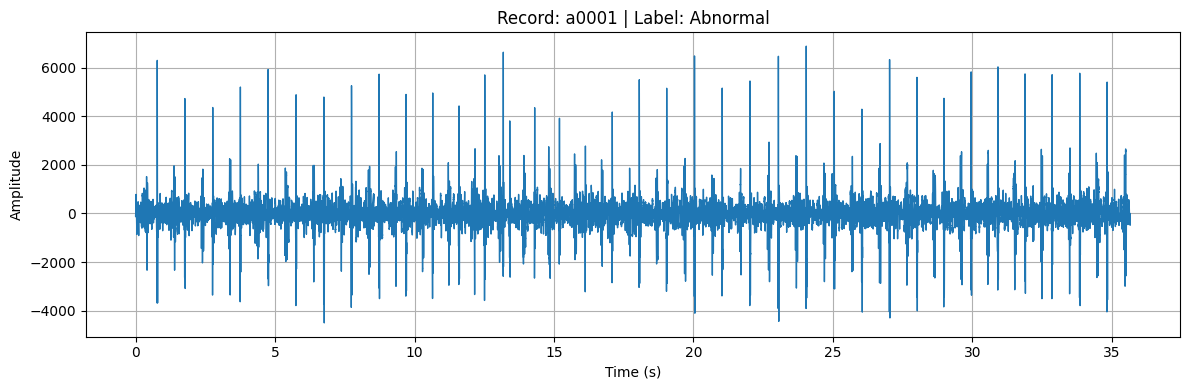

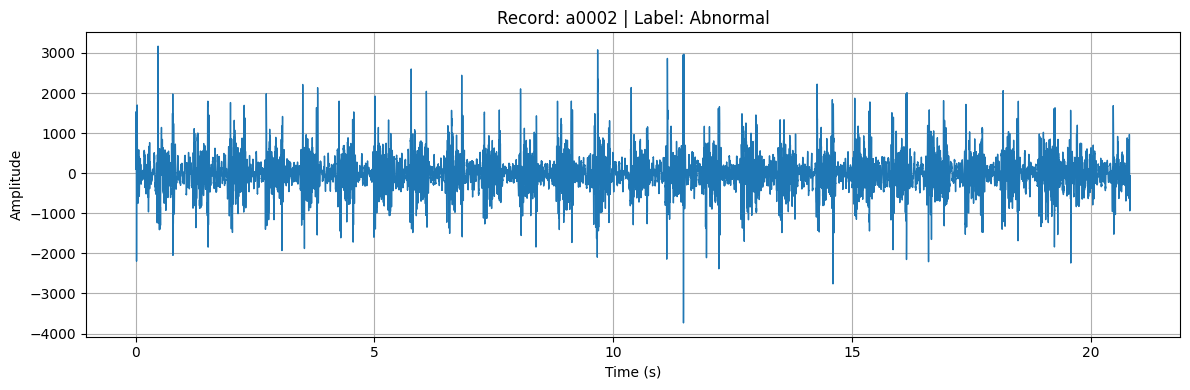

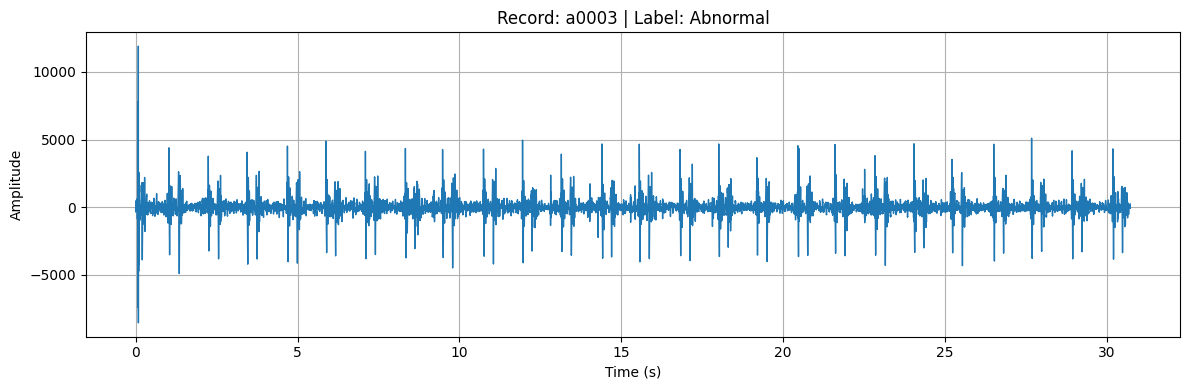

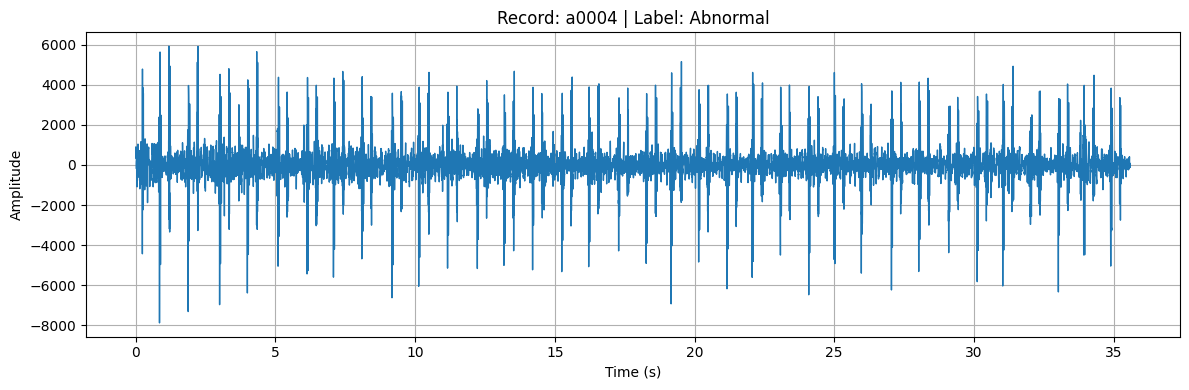

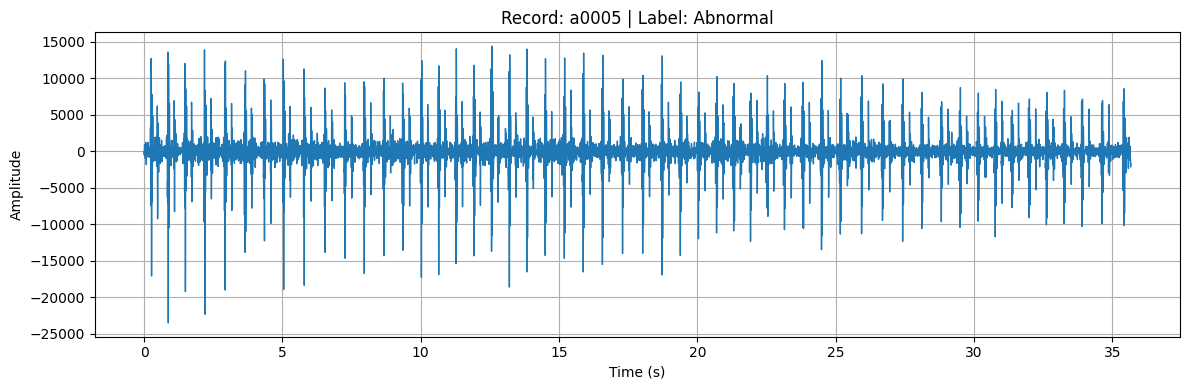

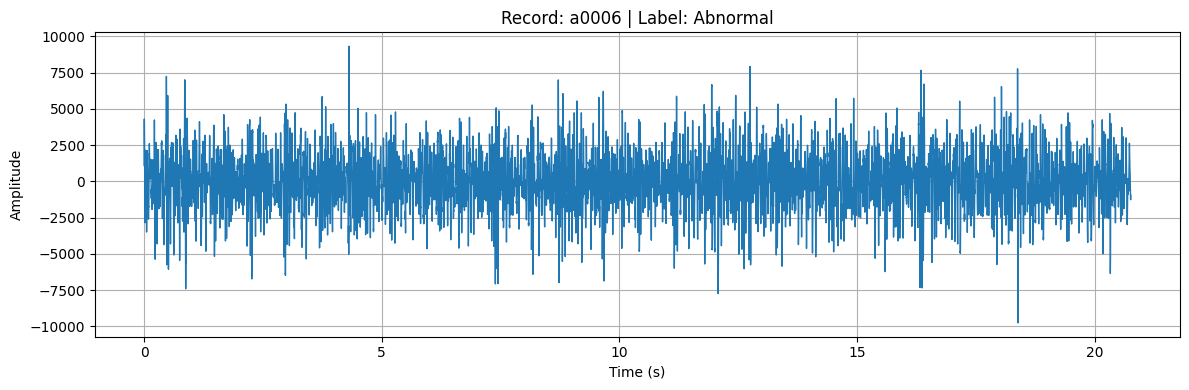

In [53]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav

# === CONFIGURATION ===
base_dir = "/home/psyche/Downloads/archive (2)"  # Change if needed
csv_path = "/home/psyche/Downloads/record_name_and_class_only.csv"

# === LOAD CSV FOR LABELS ===
df = pd.read_csv(csv_path)
df.columns = [col.strip().lower() for col in df.columns]
df = df.rename(columns={"challenge record name": "record", "class (-1=normal 1=abnormal)": "label"})

# === PICK SAMPLE RECORDS ===
sample_records = df["record"].tolist()[:6]  # Load first 6 samples (you can increase)

# === PLOT WAVEFORMS ===
for record_name in sample_records:
    wav_path = None
    # Search recursively for the .wav file
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file == f"{record_name}.wav":
                wav_path = os.path.join(root, file)
                break
        if wav_path:
            break

    if not wav_path or not os.path.exists(wav_path):
        print(f"❌ .wav file for {record_name} not found.")
        continue

    # Load WAV
    fs, data = wav.read(wav_path)
    duration = len(data) / fs
    time_axis = np.linspace(0, duration, len(data))

    # Get label
    label_value = df[df["record"] == record_name]["label"].values[0]
    label_str = "Normal" if label_value == -1 else "Abnormal"

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, data, linewidth=1)
    plt.title(f"Record: {record_name} | Label: {label_str}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [55]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os

def is_numeric_array(arr):
    """Check if the array is numeric (float/int)."""
    try:
        arr = np.asarray(arr, dtype=float)
        return True
    except Exception:
        return False

# === Paths ===
mat_dir = "/home/psyche/Downloads/archive (2)"  # Adjust to your folder
mat_files = []

for root, _, files in os.walk(mat_dir):
    for file in files:
        if file.endswith(".mat"):
            mat_files.append(os.path.join(root, file))
    if len(mat_files) >= 5:
        break  # Limit to first 5 files

# === Process and Plot ===
for mat_path in mat_files:
    print(f"🔍 Loading: {mat_path}")
    mat_data = scipy.io.loadmat(mat_path)

    # Inspect keys and try to find a valid numeric signal
    valid_signal = None
    for key in mat_data:
        if key.startswith("__"):
            continue
        candidate = mat_data[key]
        if isinstance(candidate, np.ndarray) and candidate.size > 1:
            if is_numeric_array(candidate):
                valid_signal = np.asarray(candidate).squeeze()
                signal_key = key
                break

    if valid_signal is None:
        print(f"⚠️ No valid numeric signal found in {mat_path}\n")
        continue

    # Time axis based on sampling rate (default = 1000 Hz)
    fs = 1000
    duration = len(valid_signal) / fs
    time = np.linspace(0, duration, len(valid_signal))

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(time, valid_signal)
    plt.title(f"{os.path.basename(mat_path)} | Key: {signal_key}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


🔍 Loading: /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0066_StateAns.mat
⚠️ No valid numeric signal found in /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0066_StateAns.mat

🔍 Loading: /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0077_StateAns.mat
⚠️ No valid numeric signal found in /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0077_StateAns.mat

🔍 Loading: /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0110_StateAns.mat
⚠️ No valid numeric signal found in /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0110_StateAns.mat

🔍 Loading: /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0014_StateAns.mat
⚠️ No valid numeric signal found in /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0014_StateAns.mat



/tmp/ipykernel_27451/3733619185.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  arr = np.asarray(arr, dtype=float)


⚠️ No valid numeric signal found in /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0086_StateAns.mat

🔍 Loading: /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0050_StateAns.mat
⚠️ No valid numeric signal found in /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0050_StateAns.mat

🔍 Loading: /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0107_StateAns.mat
⚠️ No valid numeric signal found in /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0107_StateAns.mat

🔍 Loading: /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0002_StateAns.mat
⚠️ No valid numeric signal found in /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0002_StateAns.mat

🔍 Loading: /home/psyche/Downloads/archive (2)/annotations/hand_corrected/training-f_StateAns/f0012_StateAns.mat


In [ ]:
import scipy.io
import numpy as np
import os

# === Path to your folder ===
mat_dir = "/home/psyche/Downloads/archive (2)"
mat_files = []

# === Collect a few .mat files ===
for root, _, files in os.walk(mat_dir):
    for file in files:
        if file.endswith(".mat"):
            mat_files.append(os.path.join(root, file))
    if len(mat_files) >= 5:
        break  # View only the first 5 files

# === Print content summaries ===
for mat_path in mat_files:
    print(f"\n📂 File: {os.path.basename(mat_path)}")
    mat_data = scipy.io.loadmat(mat_path)

    for key in mat_data:
        if key.startswith("__"):
            continue  # Skip MATLAB internal keys

        value = mat_data[key]
        print(f"🔑 Key: '{key}' | Type: {type(value)} | Shape: {np.shape(value)}")

        # Print first few values if it's numeric
        if isinstance(value, np.ndarray) and value.dtype.kind in {'i', 'f'}:
            print("   🔢 Sample Values:", value.ravel()[:10])
        elif isinstance(value, np.ndarray) and value.dtype.kind in {'U', 'S', 'O'}:
            print("   🔤 Sample (String-like):", value)
        else:
            print("   📦 Skipped non-standard value preview.")

  mat_data = scipy.io.loadmat(mat_path)

# Extract the 'state_ans' key
state_ans = mat_data.get("state_ans")
if state_ans is None:
    raise KeyError("❌ Key 'state_ans' not found in the .mat file.")

# === Flatten and extract positions + labels ===
positions = []
labels = []

for row in state_ans:
    index = int(row[0].item())  # e.g., [[919]] → 919
    label = row[1].item().item()  # e.g., [['S1']] → 'S1'
    positions.append(index)
    labels.append(label)

# === Plot labels as vertical lines with text ===
plt.figure(figsize=(14, 4))
for i, (pos, label) in enumerate(zip(positions, labels)):
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
    plt.text(pos, 1.02, label, rotation=90, verticalalignment='bottom', fontsize=8)

plt.title(f"Annotations from {os.path.basename(mat_path)}")
plt.xlabel("Sample Index")
plt.ylabel("Event Markers")
plt.ylim(0.9, 1.1)
plt.yticks([])
plt.tight_layout()
plt.grid(True)
plt.show()



📂 File: f0066_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (125, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[919]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1199]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1719]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1999]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[2799]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[3039]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[3559]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[3799]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[4719]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]]


📂 File: f0066_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (125, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[919]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1199]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1719]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1999]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


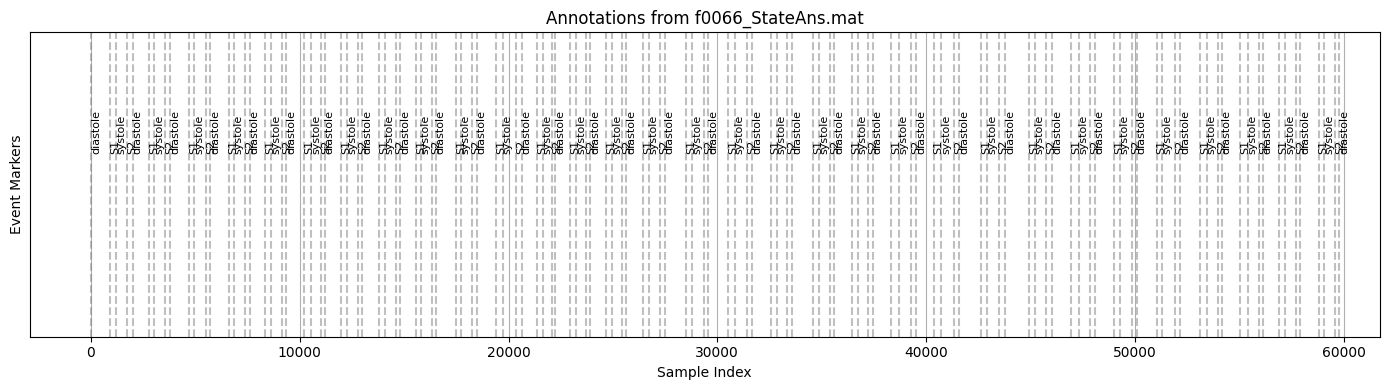


📂 File: f0077_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (182, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[719]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1039]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1399]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]


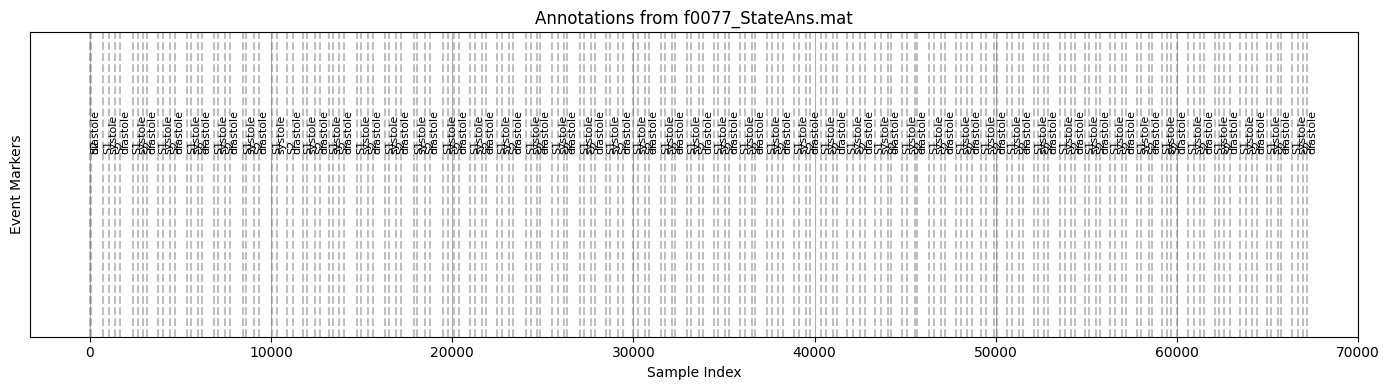


📂 File: f0110_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (186, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[439]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[719]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1079]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1279]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


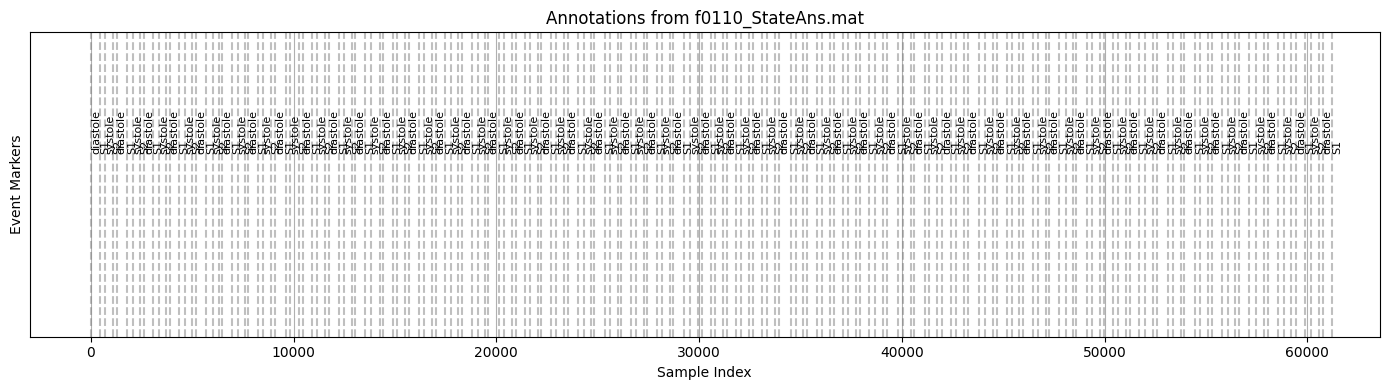


📂 File: f0014_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (187, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[599]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[839]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1399]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1599]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


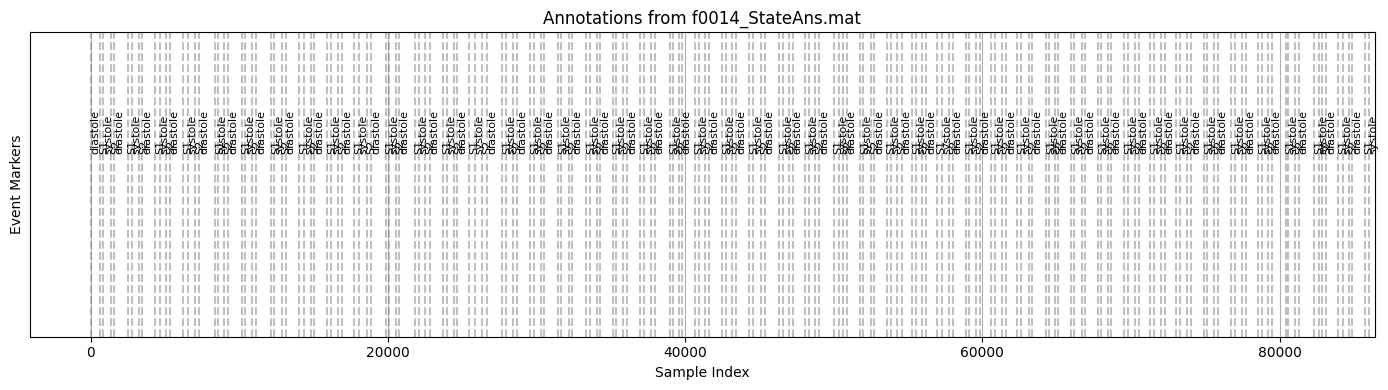


📂 File: f0055_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (183, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[279]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[479]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1119]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1399]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


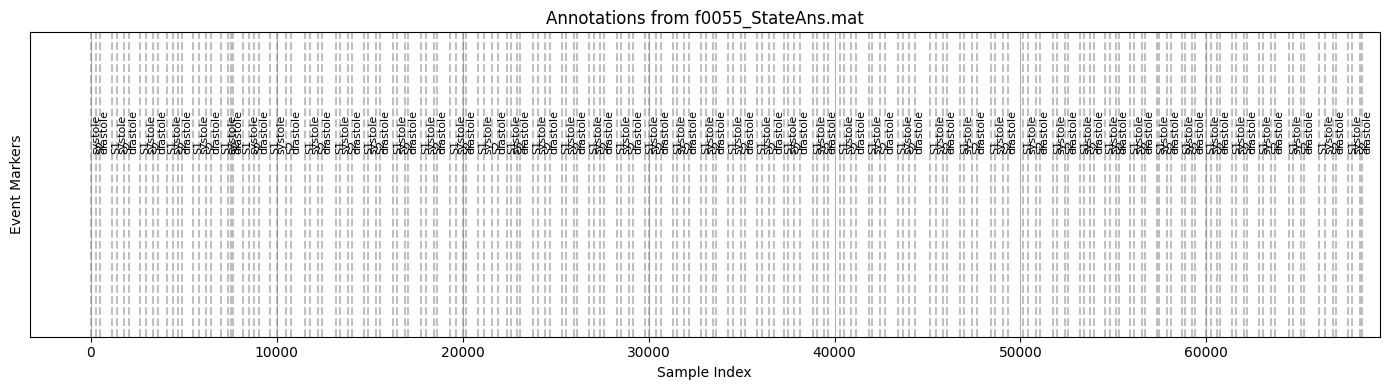


📂 File: f0051_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (157, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[399]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[759]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1239]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1559]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


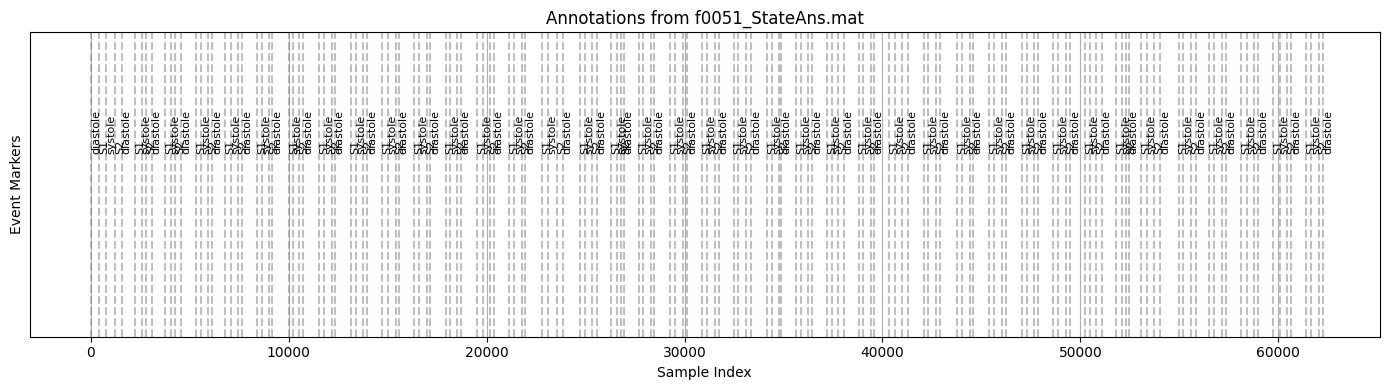


📂 File: f0010_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (143, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[402]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[601]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1467]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1645]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0010_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0109_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (171, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[159]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[399]], dtype=uint16)
  array([[

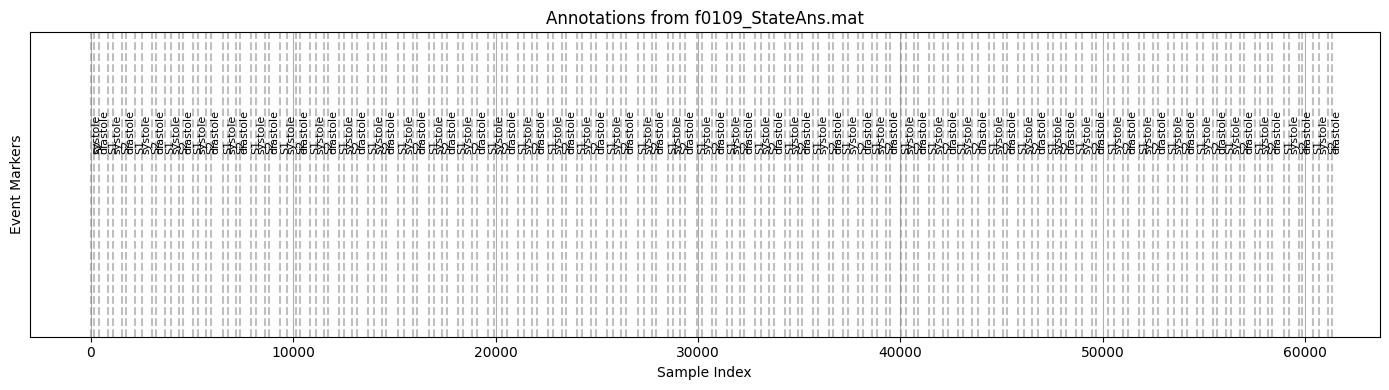


📂 File: f0086_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (186, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[319]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[559]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[999]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1199]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


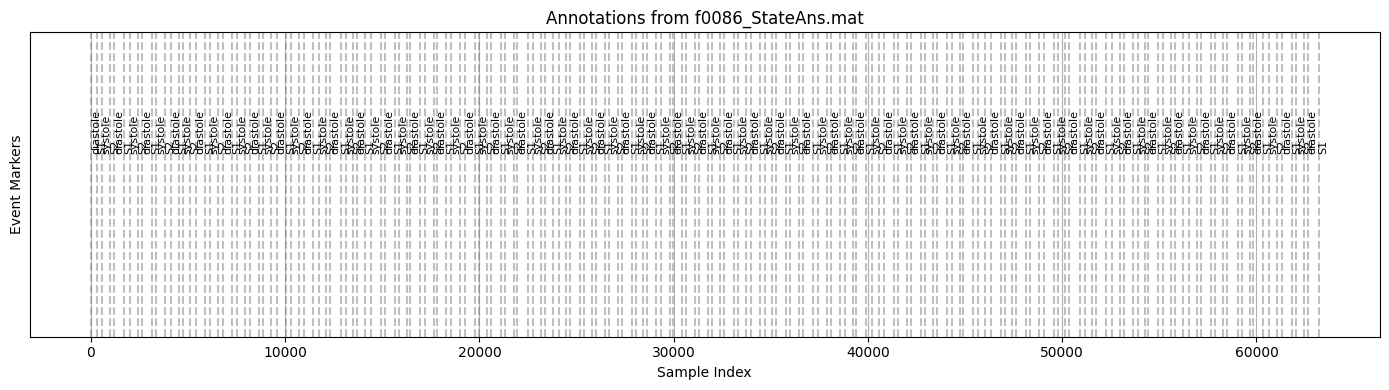


📂 File: f0050_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (127, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[639]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[959]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1559]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1879]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


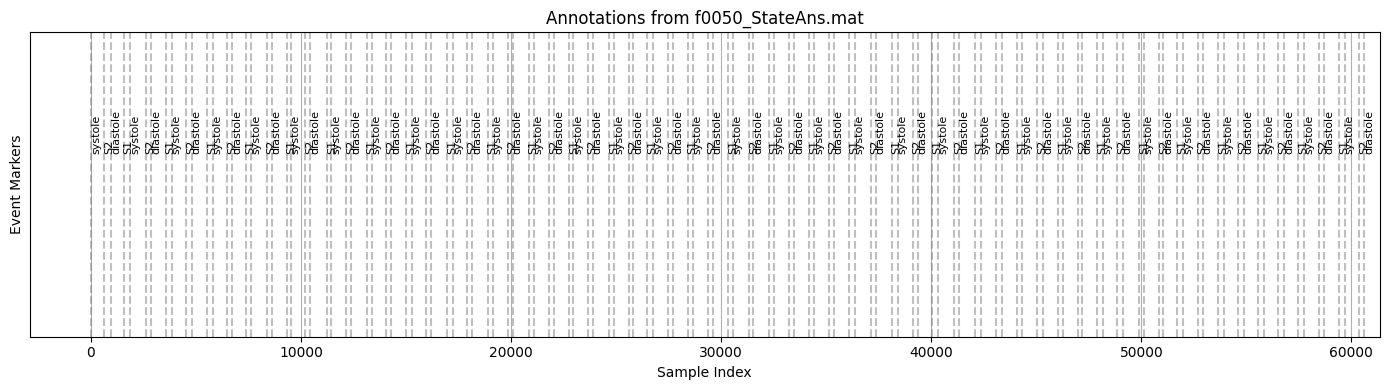


📂 File: f0107_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (166, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[519]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[759]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1319]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]]


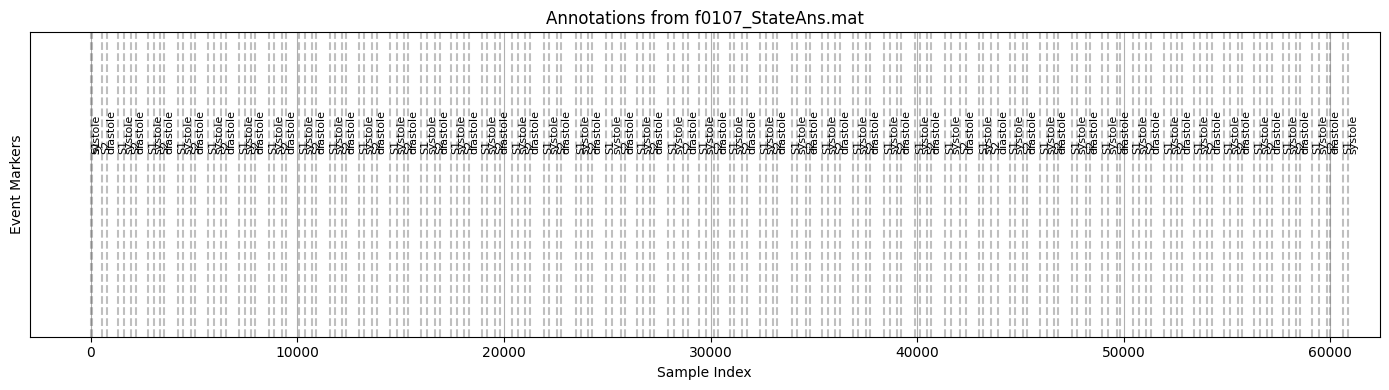


📂 File: f0002_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (158, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[3279]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[3879]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[4159]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[4559]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0002_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0012_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (174, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[10479]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[11079]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[11359]], dtype=uint16)
  array([[array(['systole'], dtype='<U7

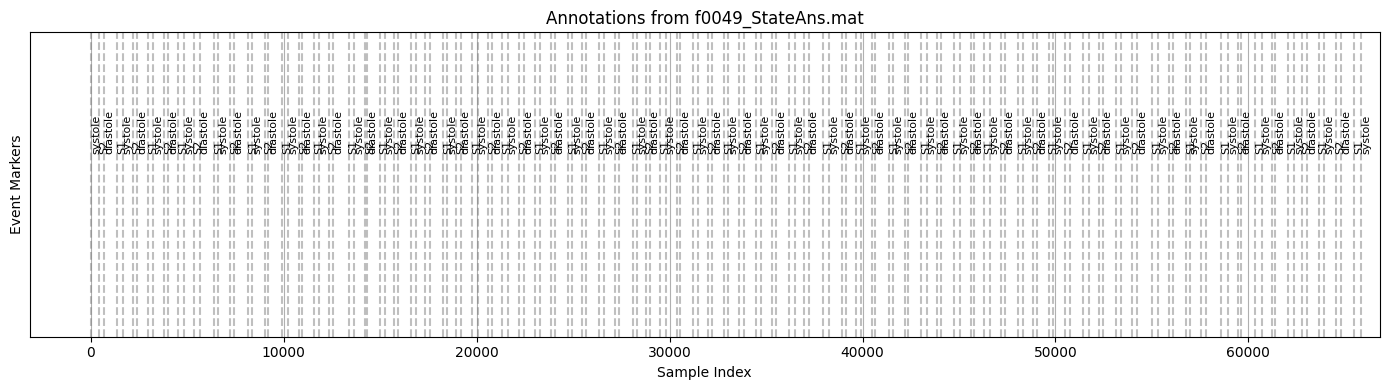


📂 File: f0019_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (168, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[799]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1039]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1439]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]


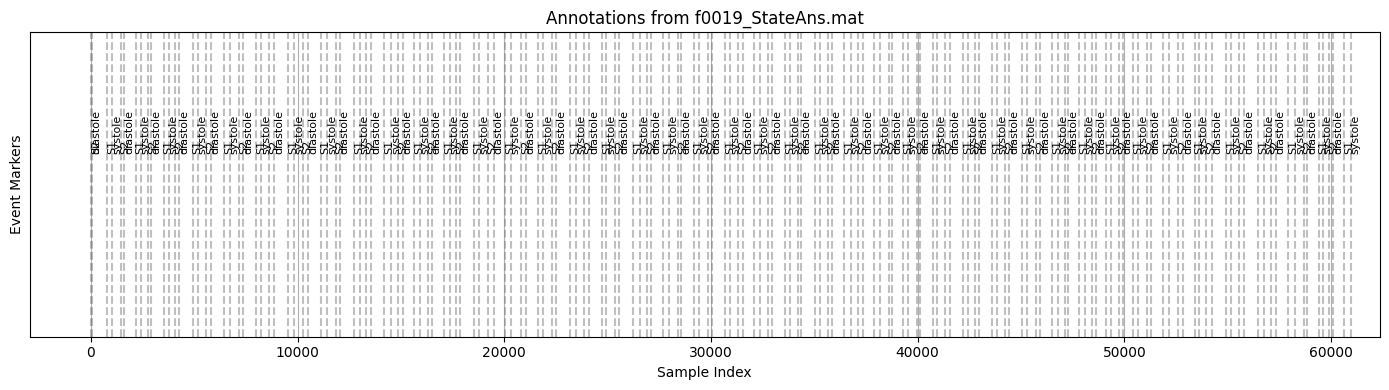


📂 File: f0025_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (148, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[119]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[399]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1519]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1759]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


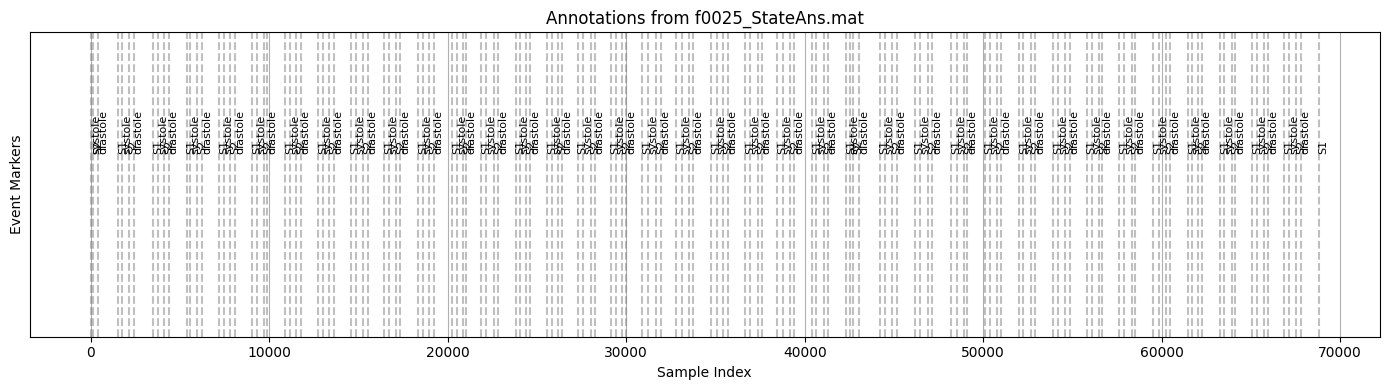


📂 File: f0056_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (141, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1039]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1399]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1599]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1839]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


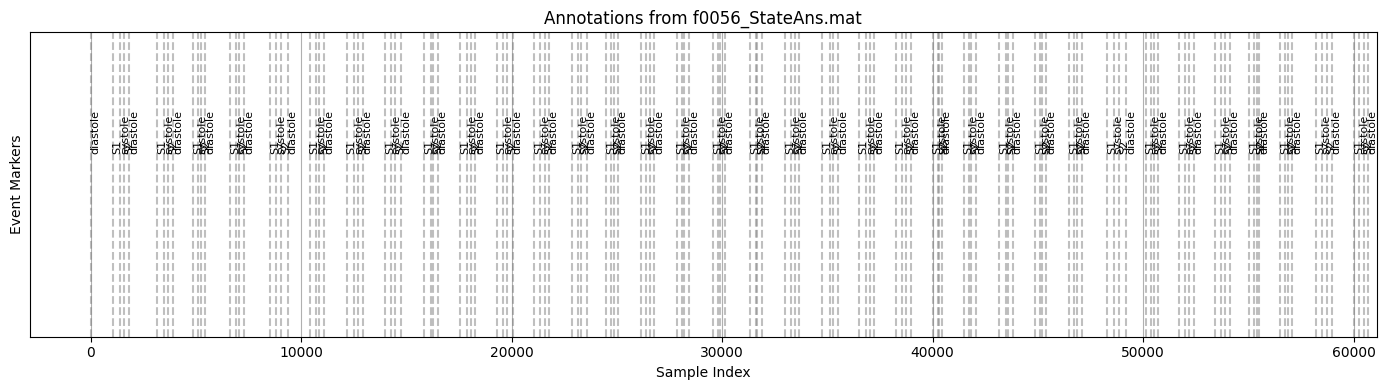


📂 File: f0081_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (170, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[639]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[879]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1399]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]]


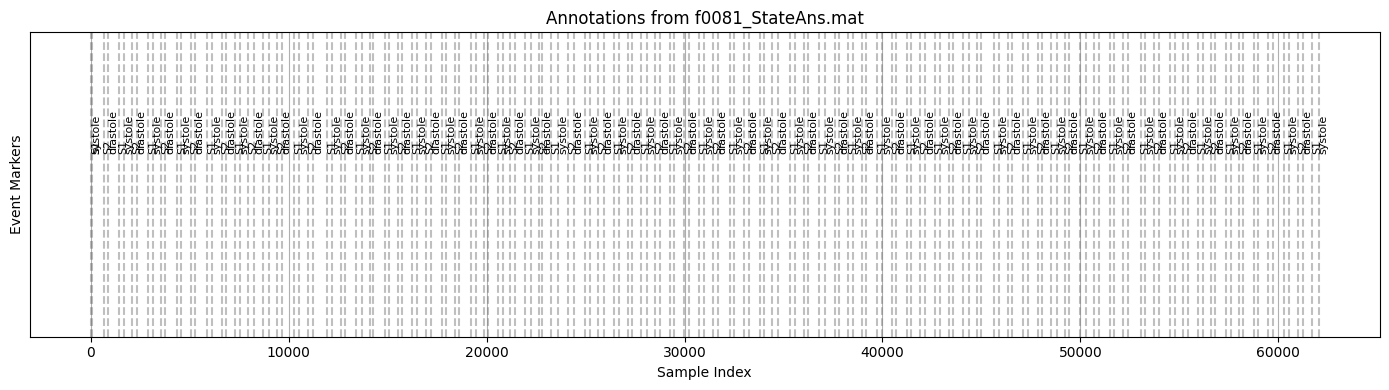


📂 File: f0071_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (235, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['S2'], dtype='<U2')]
 [array([[39]], dtype=uint8) array(['diastole'], dtype='<U8')]
 [array([[399]], dtype=uint16) array(['S1'], dtype='<U2')]
 [array([[599]], dtype=uint16) array(['systole'], dtype='<U7')]
 [array([[999]], dtype=uint16) array(['S2'], dtype='<U2')]]
⚠️ Failed to plot 'state_ans' from f0071_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0062_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (155, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[359]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[679]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1519]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [arr

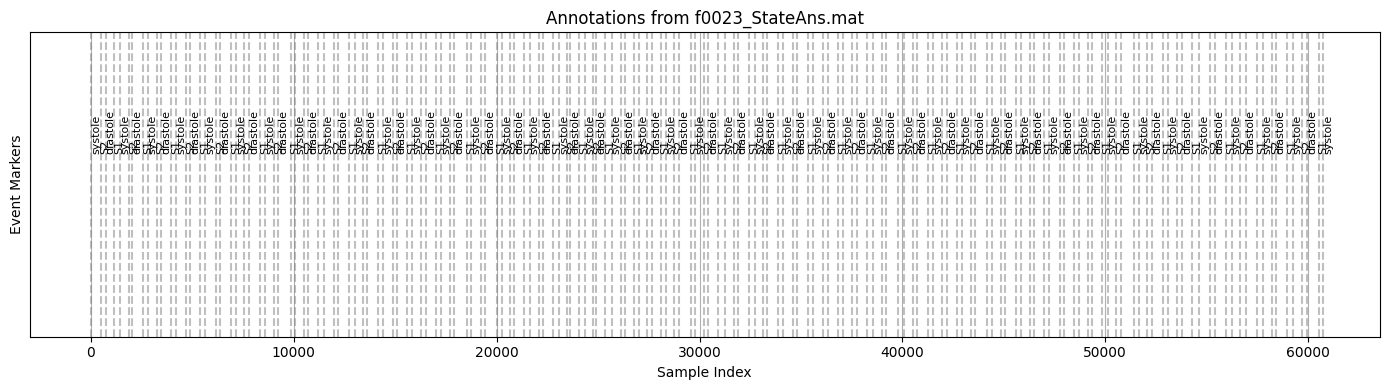


📂 File: f0041_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (36, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[44601]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[45144]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[45645]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[45885]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0041_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0112_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (169, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[517]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[674]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array(

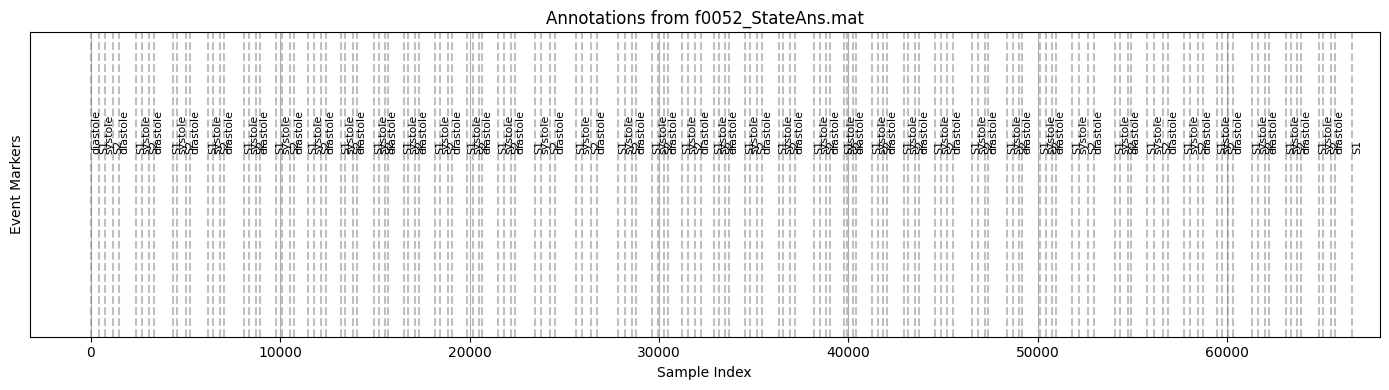


📂 File: f0094_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (167, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[199]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[359]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[919]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1159]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


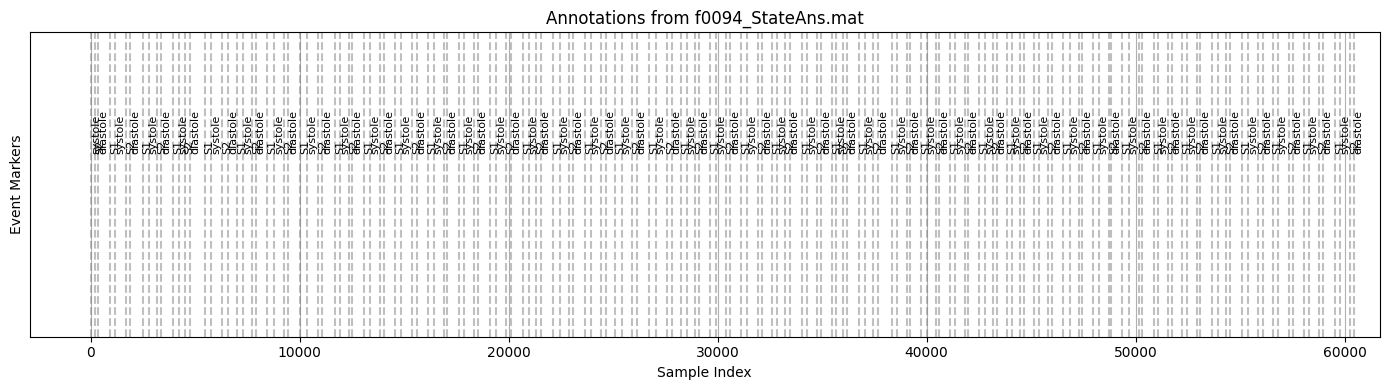


📂 File: f0080_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (131, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[399]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[679]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1559]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1799]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


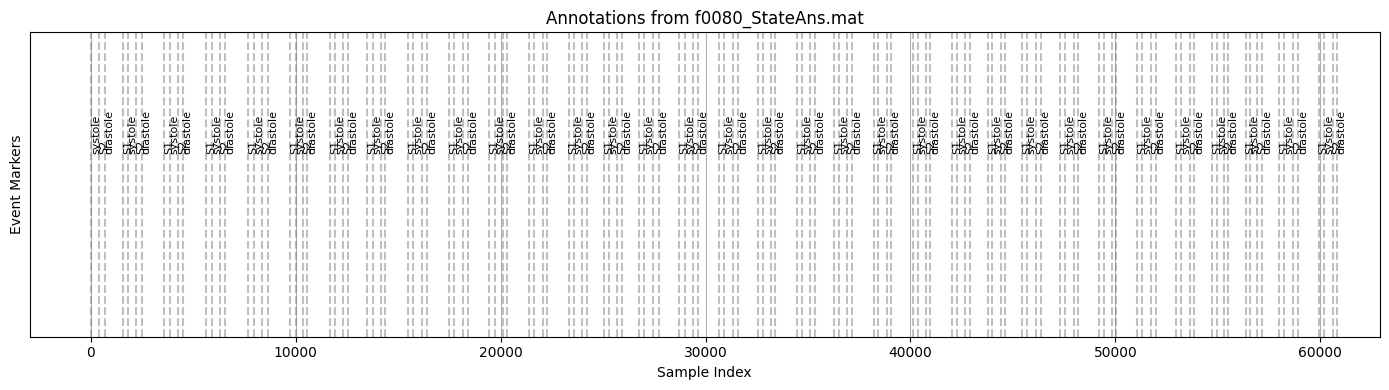


📂 File: f0018_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (151, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[392]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[569]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1091]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1258]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0018_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0070_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (147, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[319]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[479]], dtype=uint16)
  array([

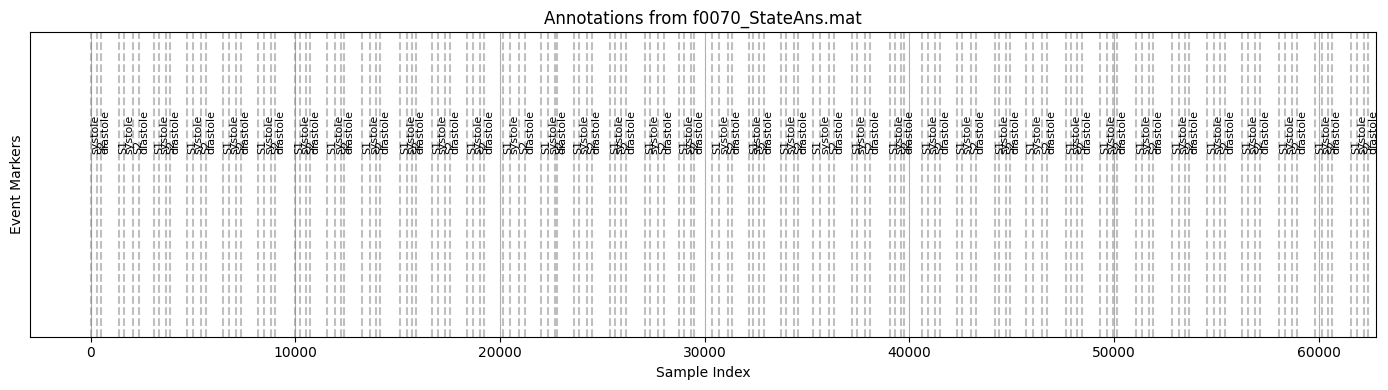


📂 File: f0078_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (153, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[199]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[359]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1199]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1439]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


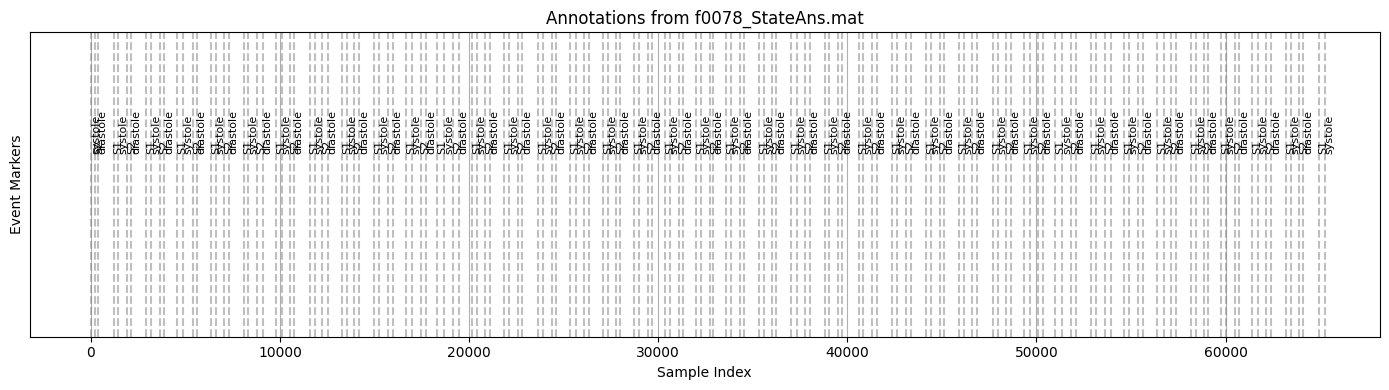


📂 File: f0072_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (154, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[22759]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[23119]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[23359]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[23639]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0072_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0076_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (139, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[279]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([

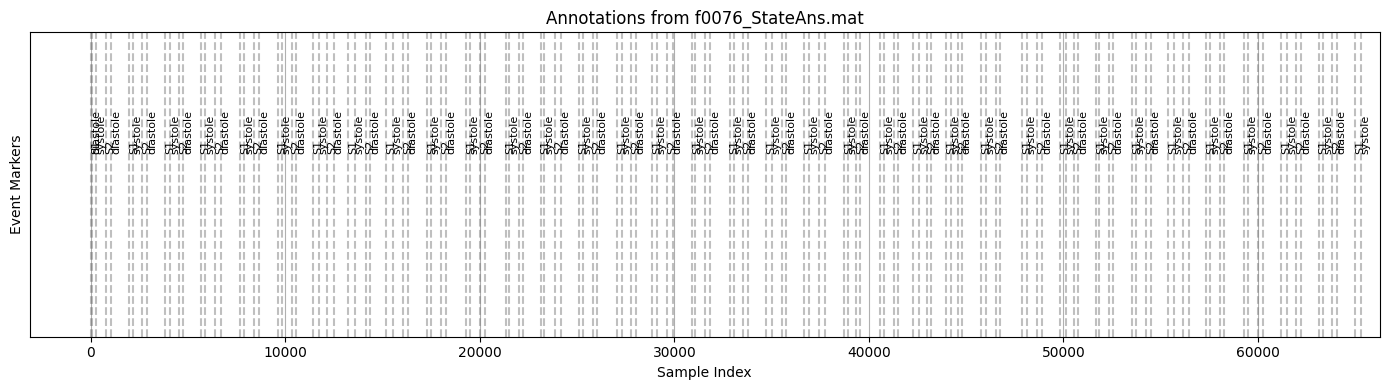


📂 File: f0011_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (185, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[61599]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[62079]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[62319]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[62679]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0011_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0098_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (144, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[959]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1199

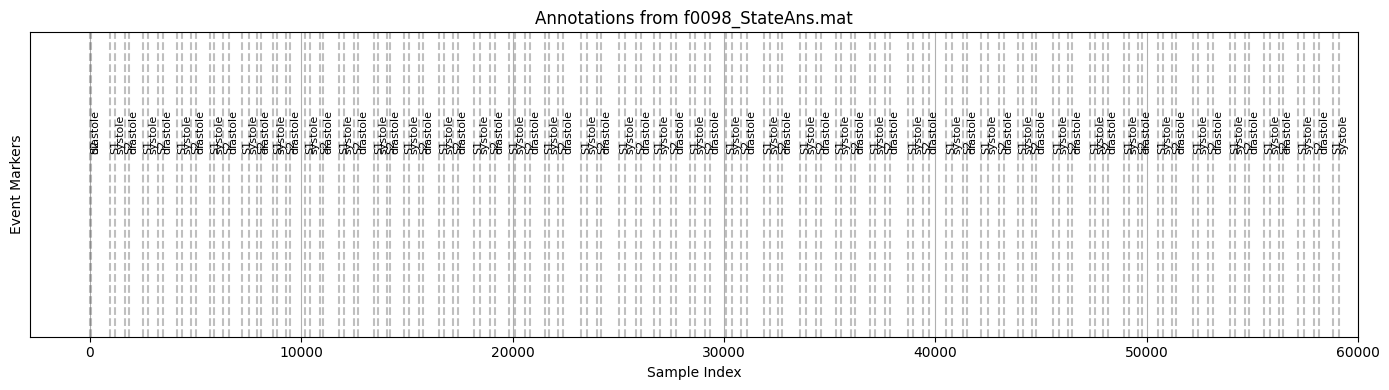


📂 File: f0093_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (143, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[479]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[759]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1239]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1439]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


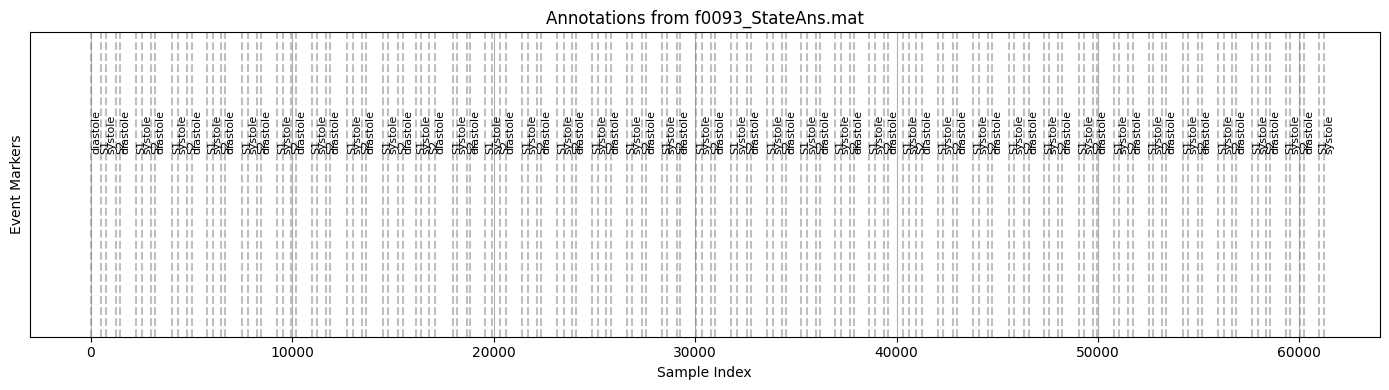


📂 File: f0060_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (145, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1279]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1559]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1799]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]


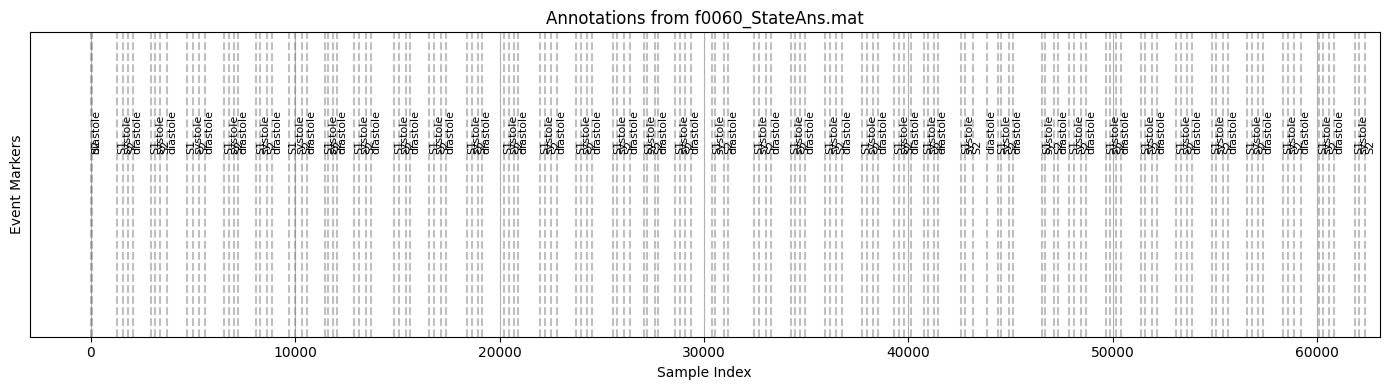


📂 File: f0032_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (2, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[61632]], dtype=uint16) array(['N)'], dtype='<U2')]]
⚠️ Failed to plot 'state_ans' from f0032_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0006_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (190, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[239]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[519]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[959]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1159]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


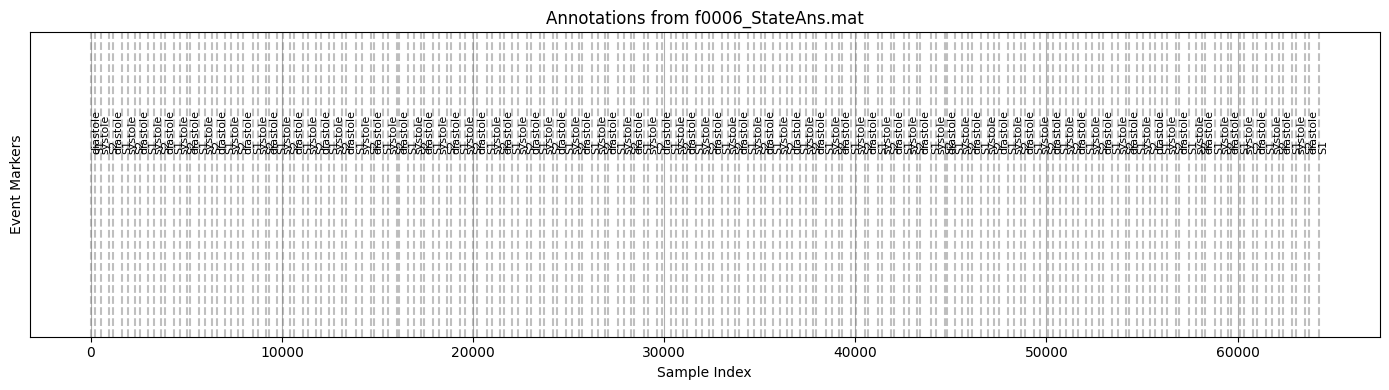


📂 File: f0067_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (93, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1599]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1919]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[2359]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[2639]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0067_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0068_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (102, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[26239]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[27279]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array

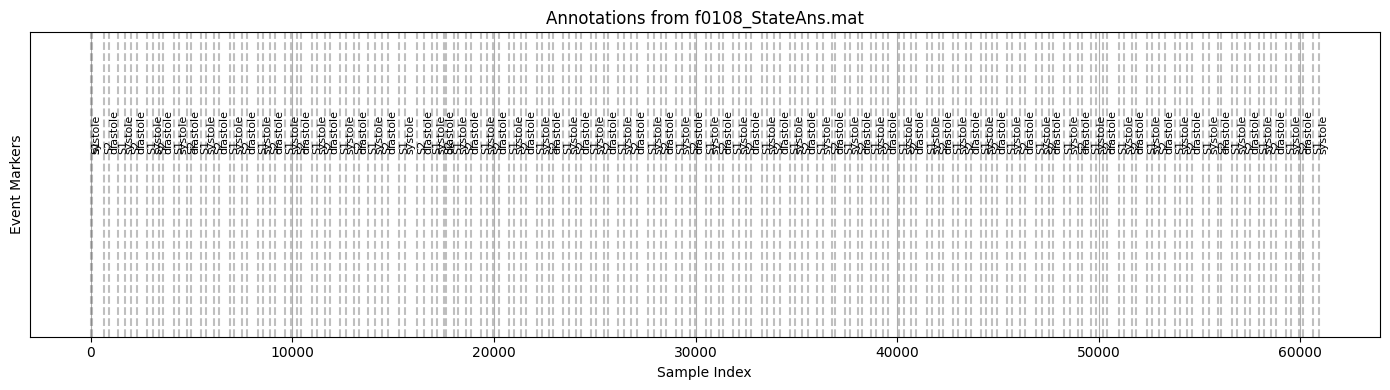


📂 File: f0043_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (2, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[70368]], dtype=int32) array(['N)'], dtype='<U2')]]
⚠️ Failed to plot 'state_ans' from f0043_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0030_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (157, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[439]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[799]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1119]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1359]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


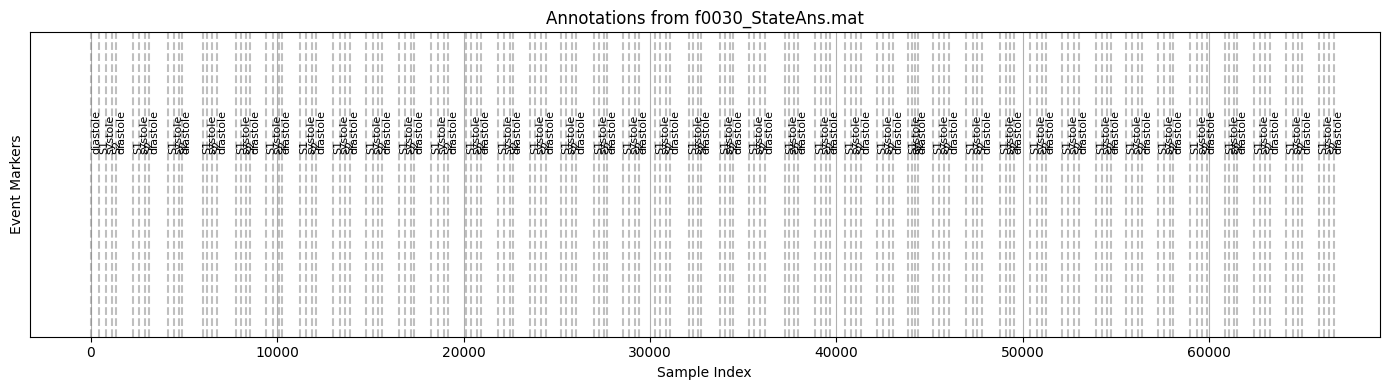


📂 File: f0074_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (184, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[199]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[799]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1079]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1519]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]


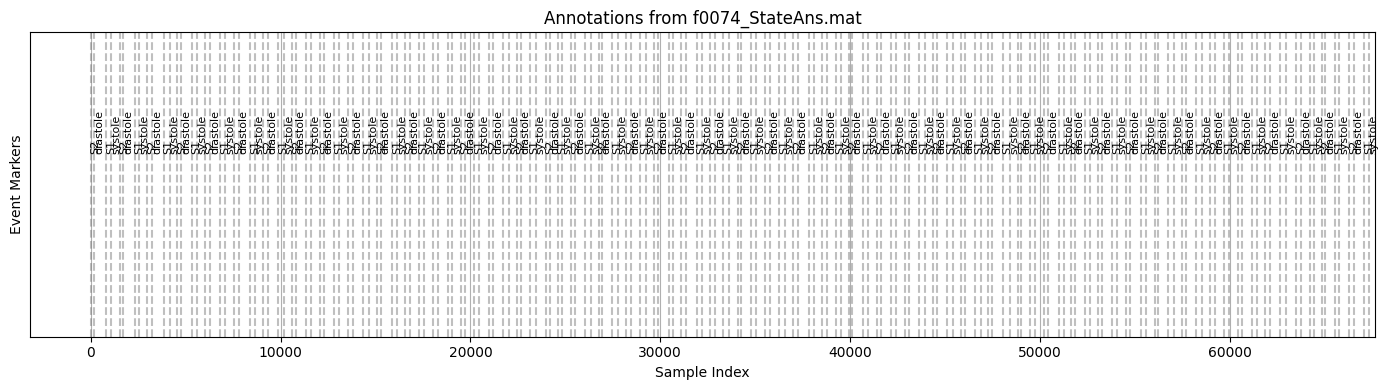


📂 File: f0065_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (124, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[679]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[959]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[2119]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]]


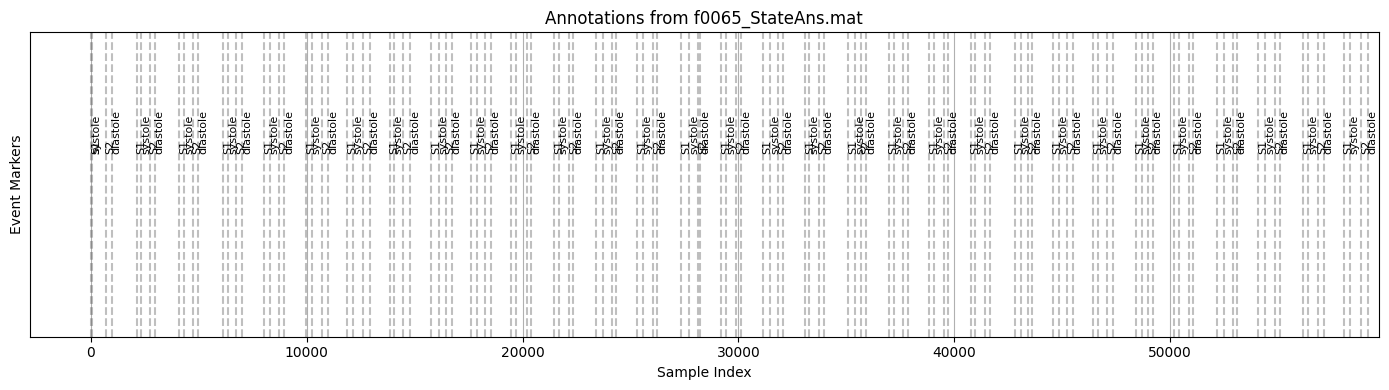


📂 File: f0097_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (94, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[77759]], dtype=int32) array(['N)'], dtype='<U2')]
 [array([[78399]], dtype=int32)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[78639]], dtype=int32)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[79159]], dtype=int32)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0097_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0004_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (156, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[519]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[719]], dty

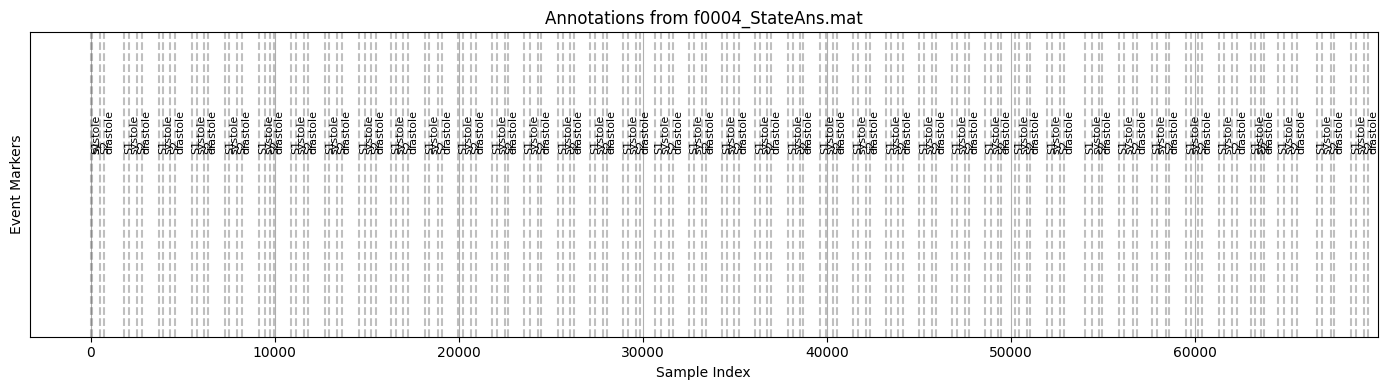


📂 File: f0013_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (182, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[759]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[999]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1519]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]


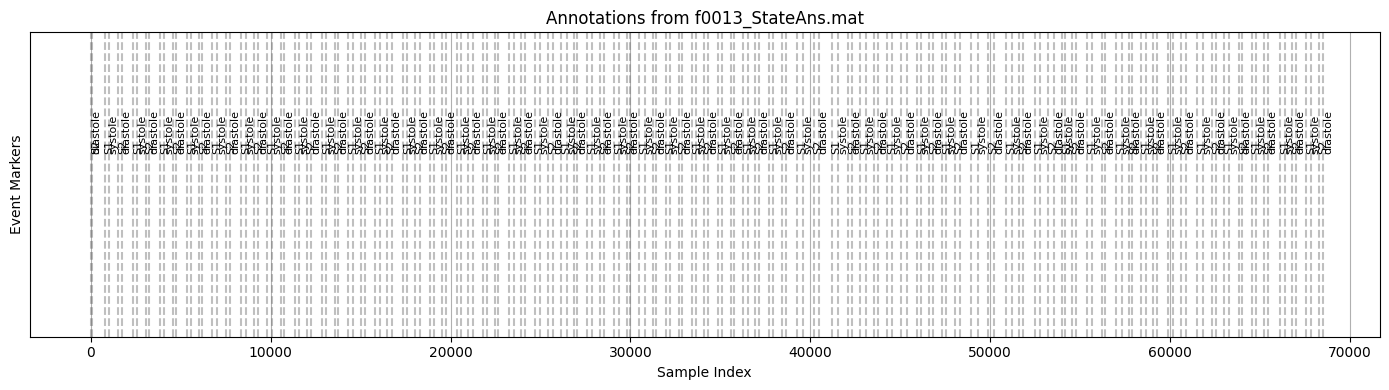


📂 File: f0090_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (238, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[279]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[439]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[759]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1039]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


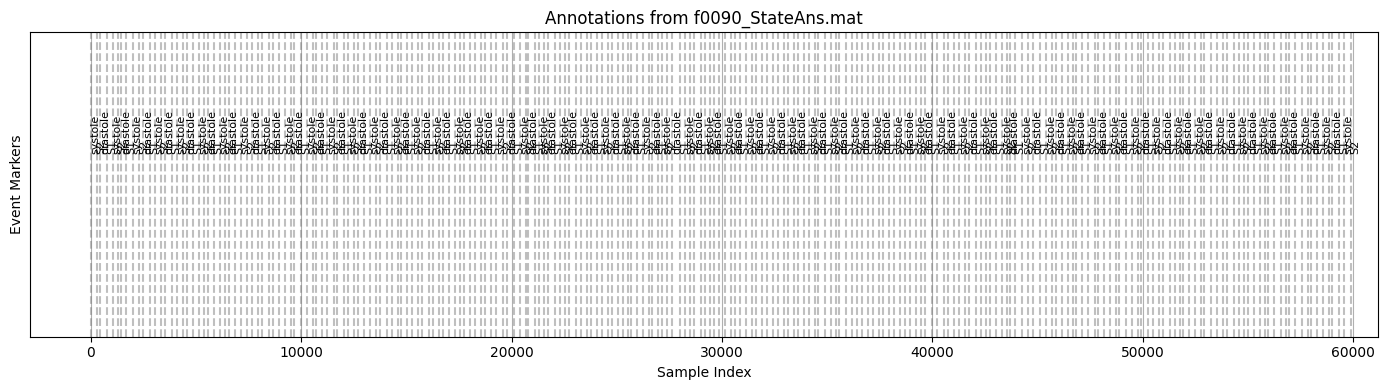


📂 File: f0054_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (185, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[479]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[639]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1079]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1319]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


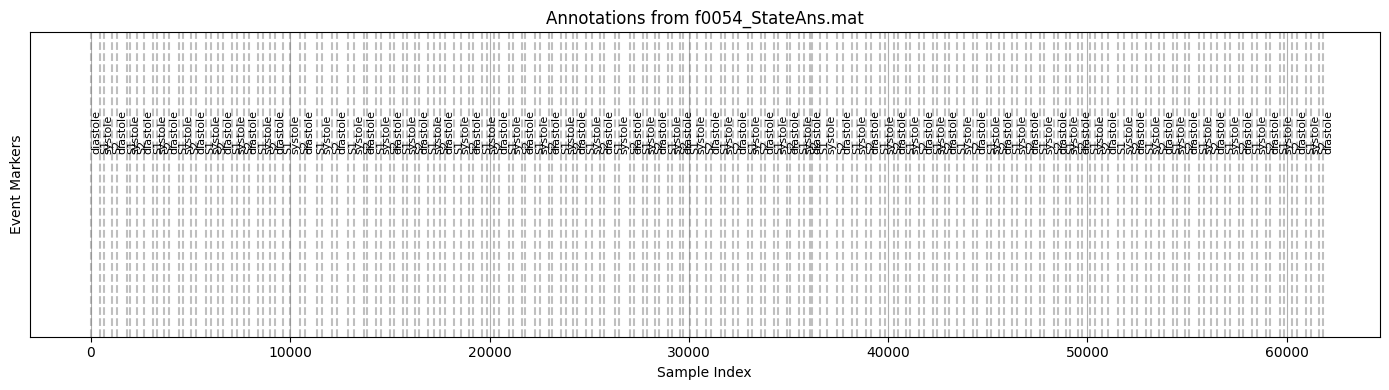


📂 File: f0091_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (88, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[39799]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[40399]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[40599]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[40999]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0091_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0035_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (139, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[319]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[599]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array(

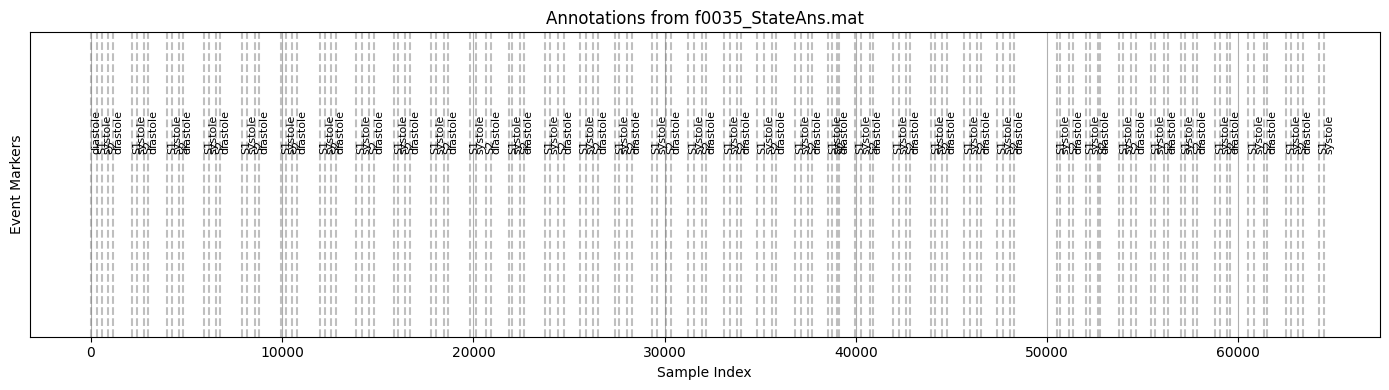


📂 File: f0009_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (147, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[239]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[559]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1359]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1719]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


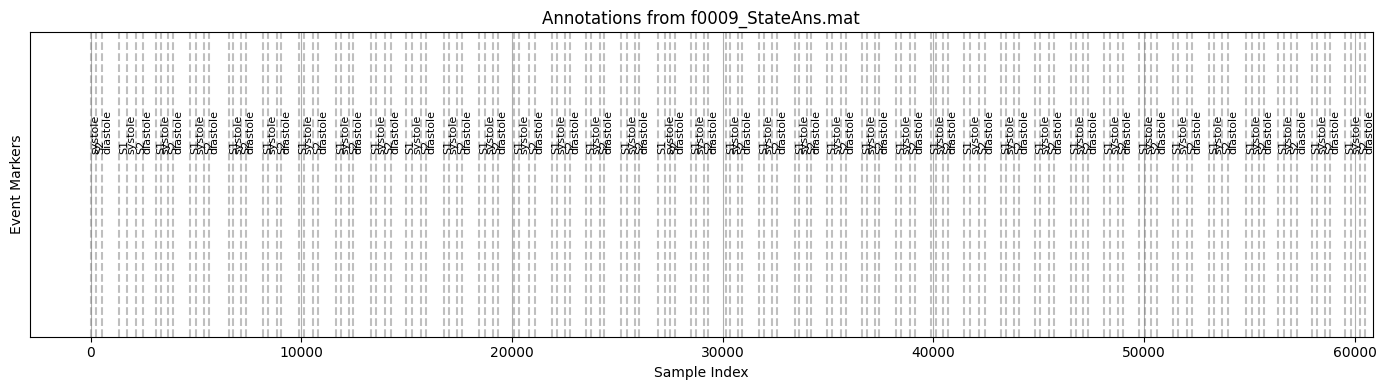


📂 File: f0073_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (159, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[359]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[599]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1239]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1519]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


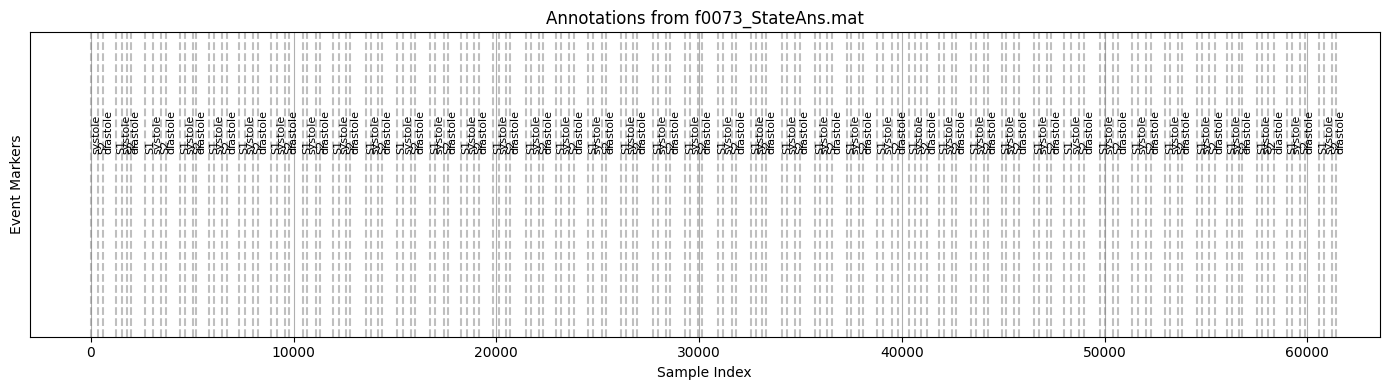


📂 File: f0102_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (211, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[399]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[639]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1079]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]]


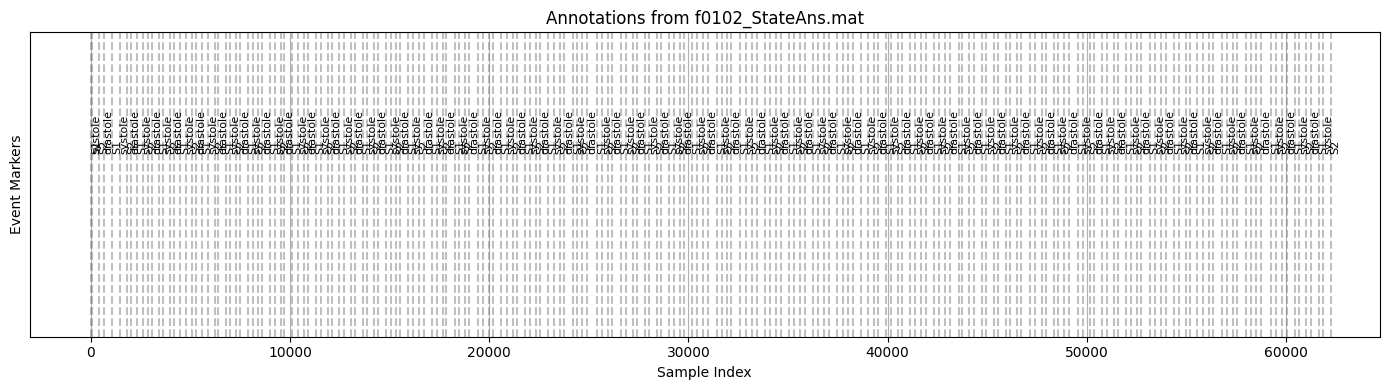


📂 File: f0031_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (95, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1199]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1439]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1879]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0031_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0021_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (198, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[519]], dtype=uint16)
  array([[array([

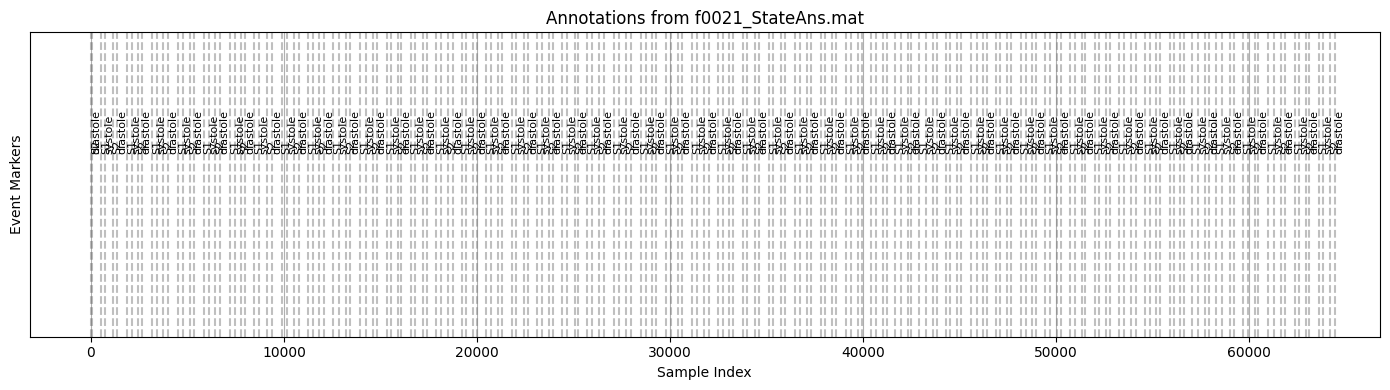


📂 File: f0036_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (159, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[279]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[519]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[959]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1119]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


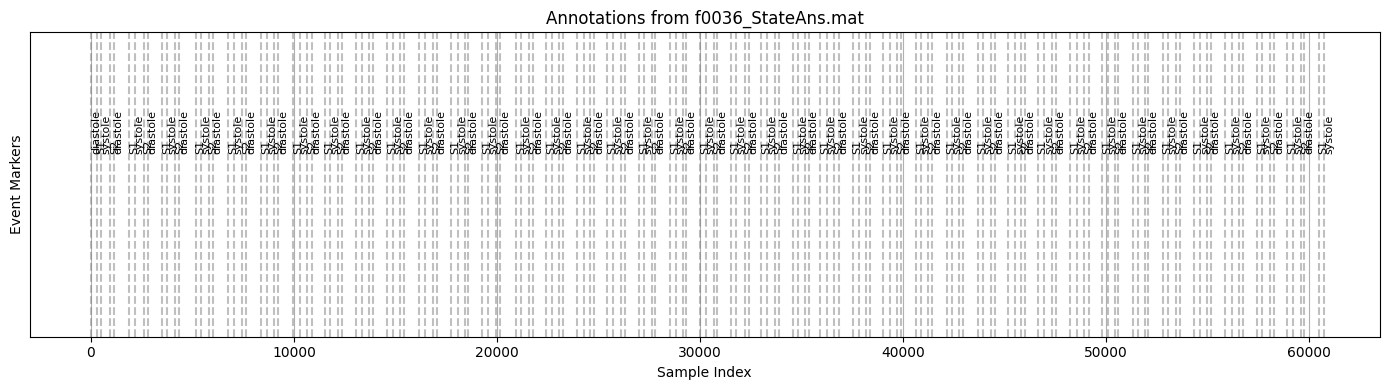


📂 File: f0057_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (2, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[62112]], dtype=uint16) array(['N)'], dtype='<U2')]]
⚠️ Failed to plot 'state_ans' from f0057_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0015_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (177, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[279]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[439]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[959]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1199]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


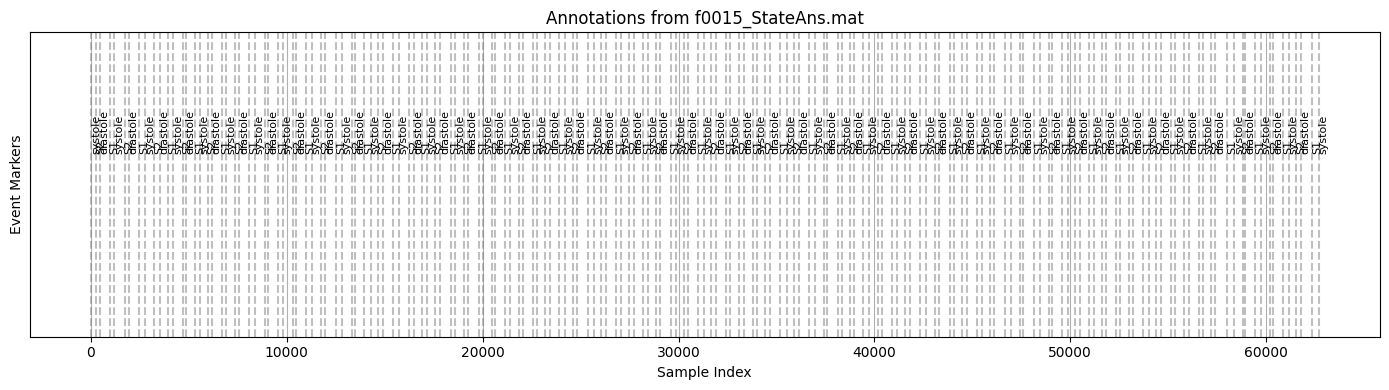


📂 File: f0100_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (159, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[359]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[559]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[959]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1159]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


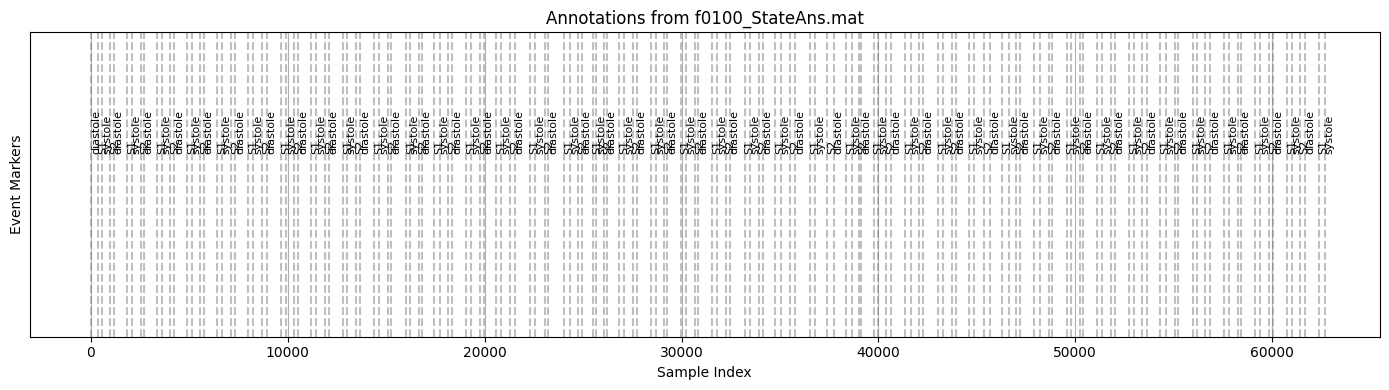


📂 File: f0092_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (188, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[559]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[839]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1279]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]


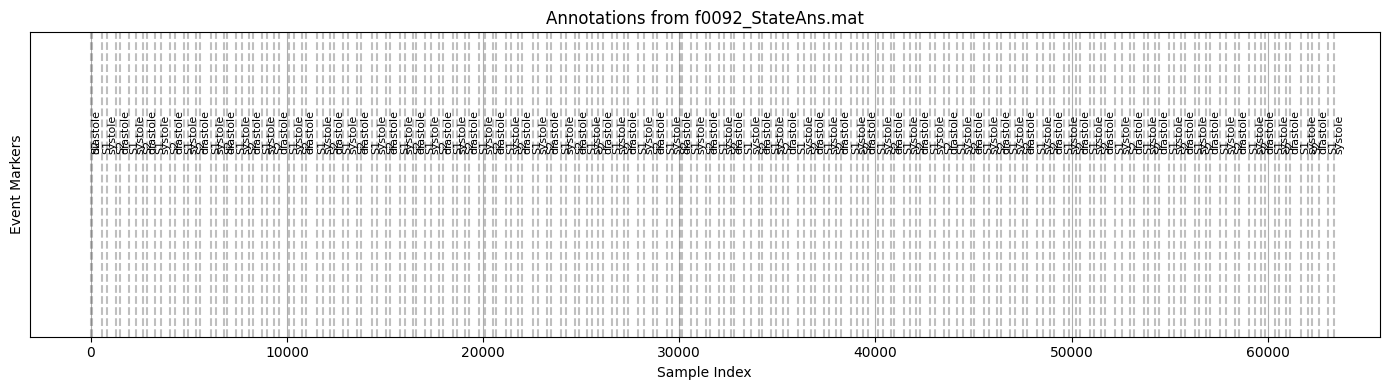


📂 File: f0111_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (205, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[439]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[679]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[919]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1119]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


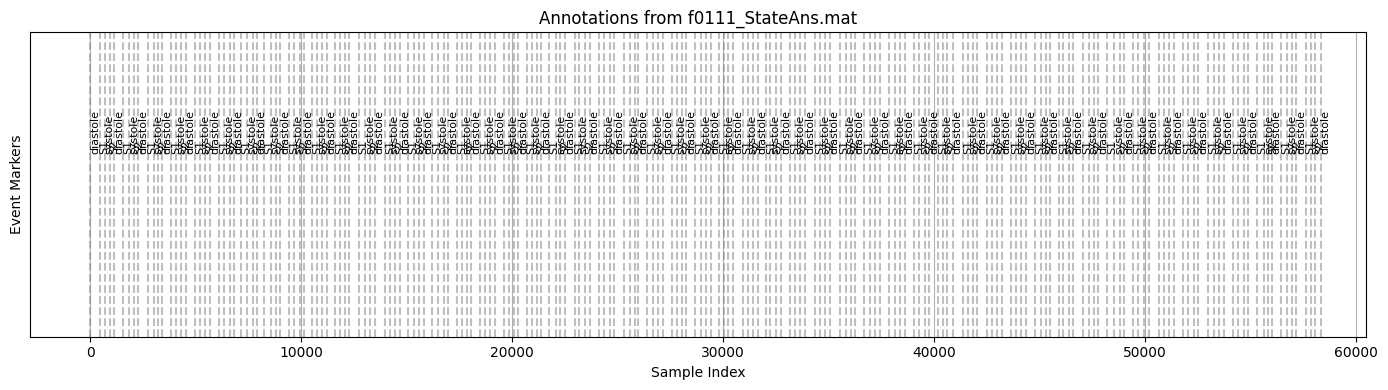


📂 File: f0022_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (156, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[479]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[679]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1199]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1439]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


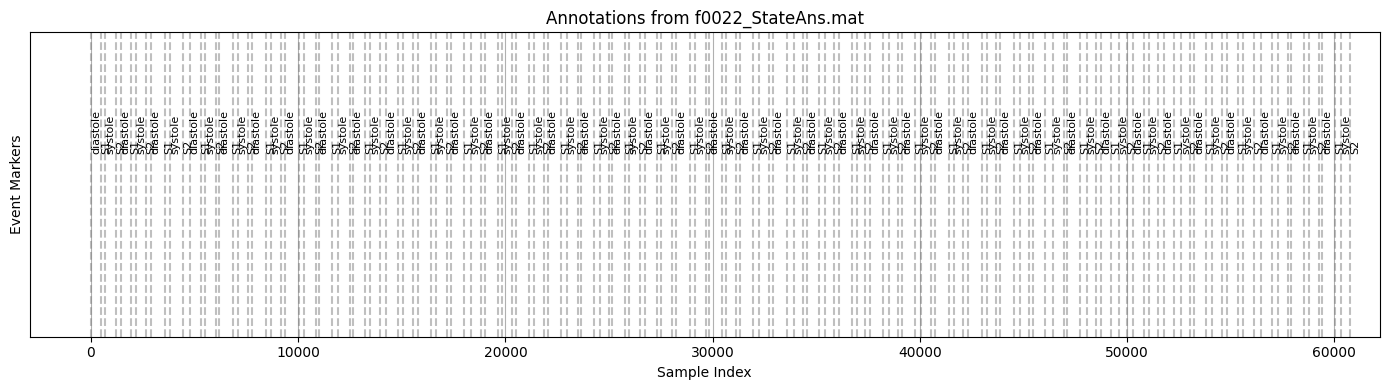


📂 File: f0003_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (167, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[279]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1079]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1359]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


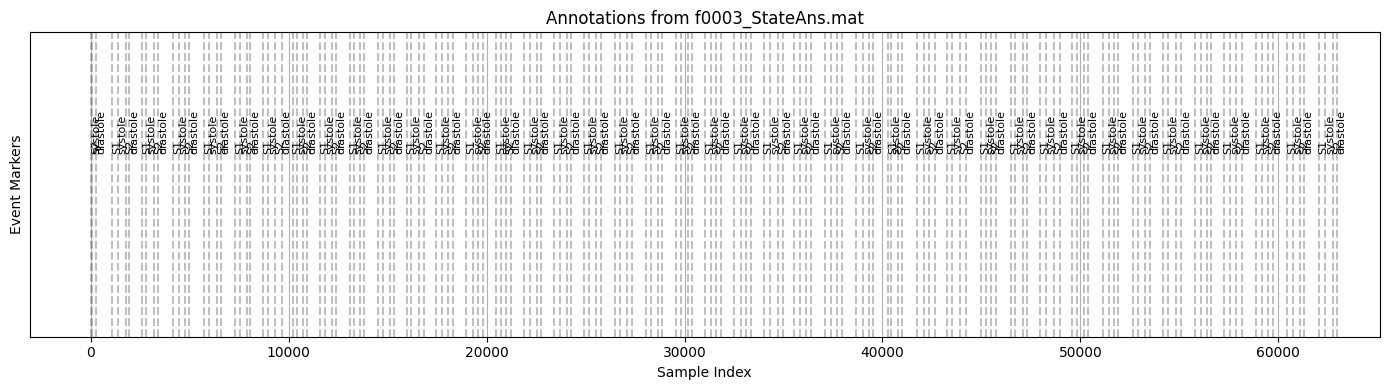


📂 File: f0029_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (220, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[6479]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[6919]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[7199]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[7479]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0029_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0079_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (301, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[239]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[479]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[79

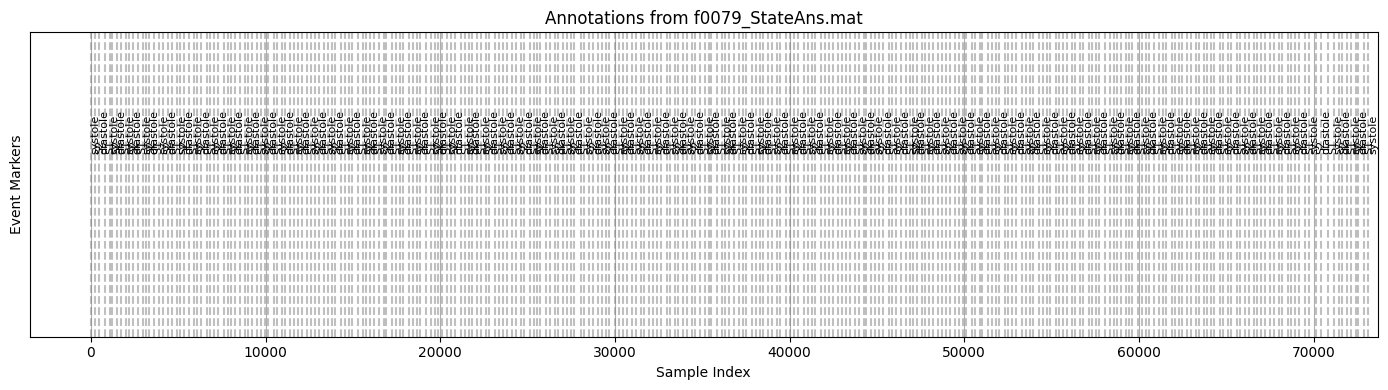


📂 File: f0017_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (174, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[279]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[519]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1319]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]]


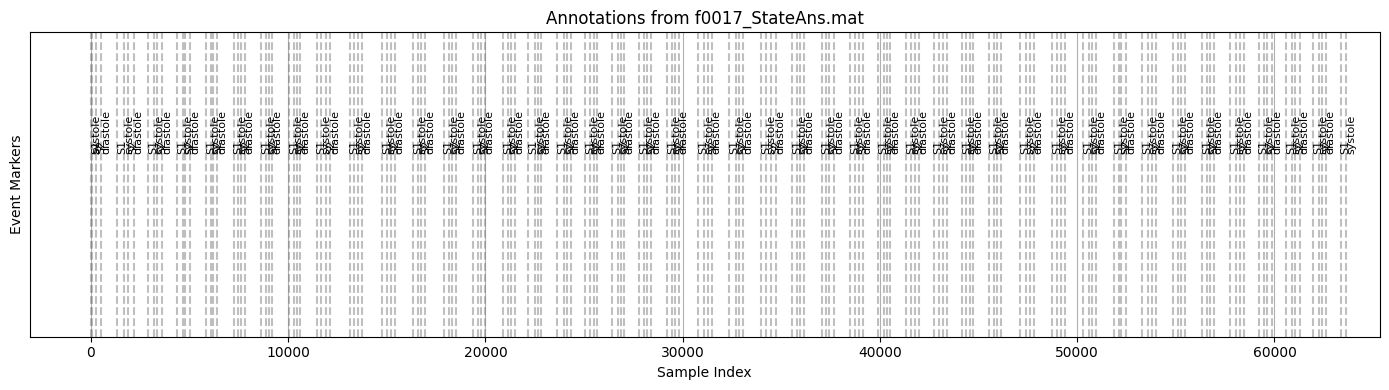


📂 File: f0083_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (184, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[279]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[839]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1119]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0083_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0040_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (125, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[132]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[327]], dtype=uint16)
  array([[arr

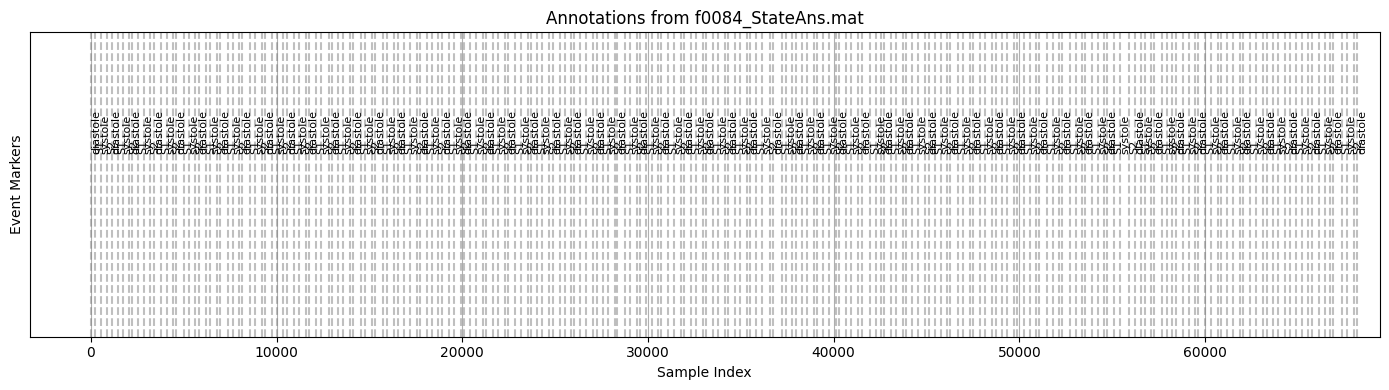


📂 File: f0082_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (117, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[759]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[999]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1439]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1639]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


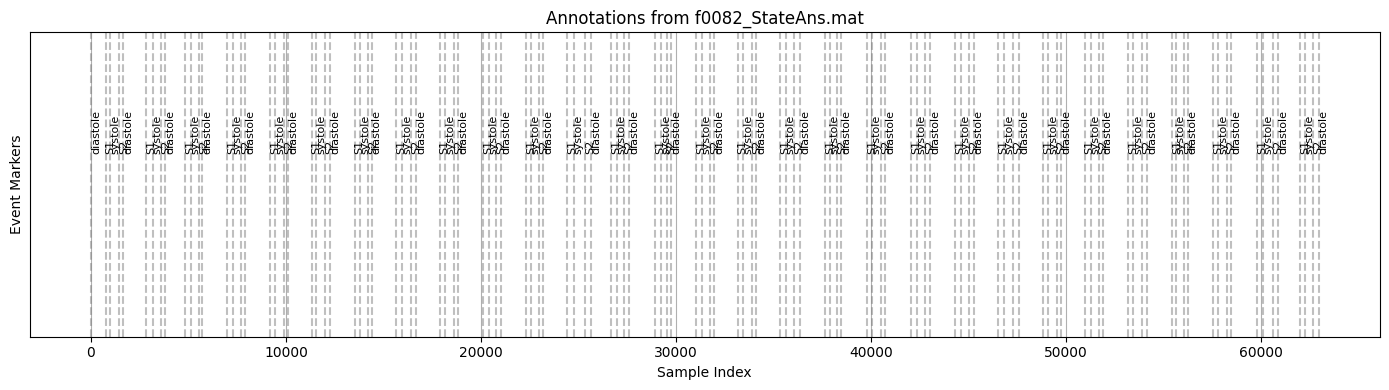


📂 File: f0047_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (250, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[359]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[719]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[919]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]


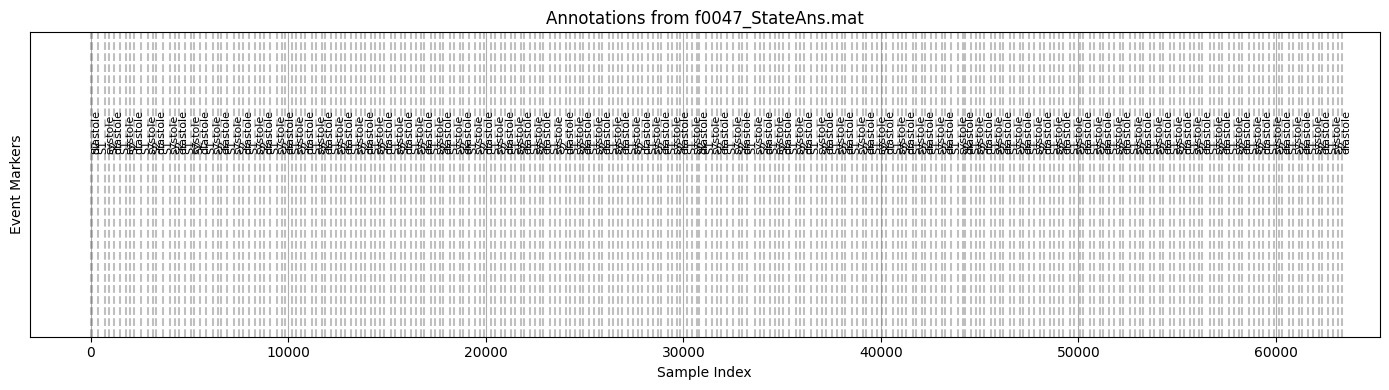


📂 File: f0106_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (152, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[399]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[639]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1159]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1399]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0106_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0088_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (179, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[559]], dtype=uint16)
  array([[

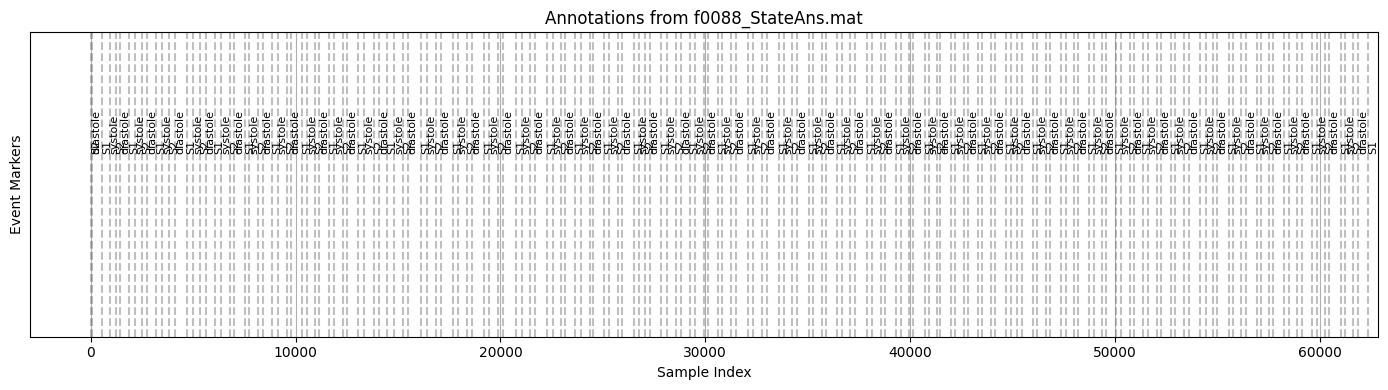


📂 File: f0026_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (129, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[308]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[517]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1697]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1916]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0026_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0059_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (276, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[399]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[719]], dtype=uint16)
  array(

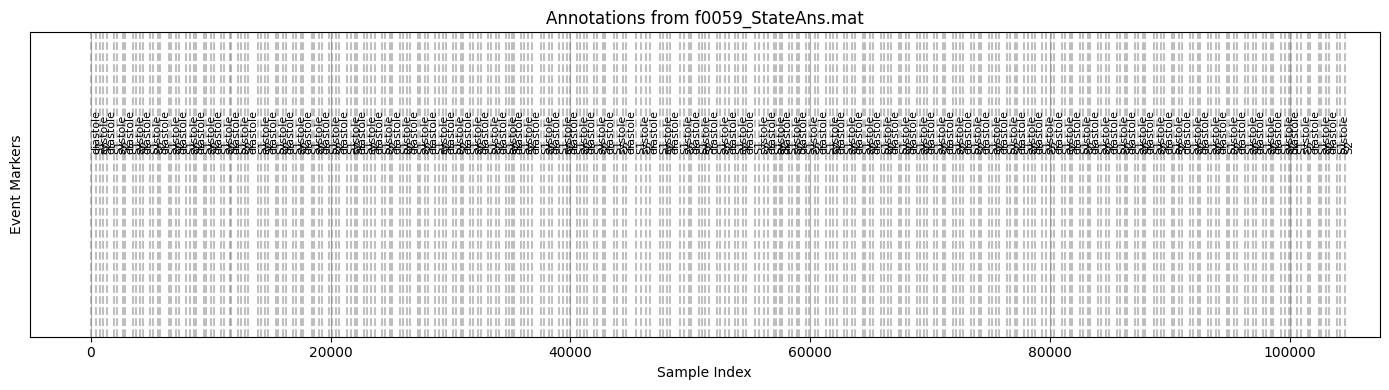


📂 File: f0044_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (159, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[879]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1079]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1439]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]


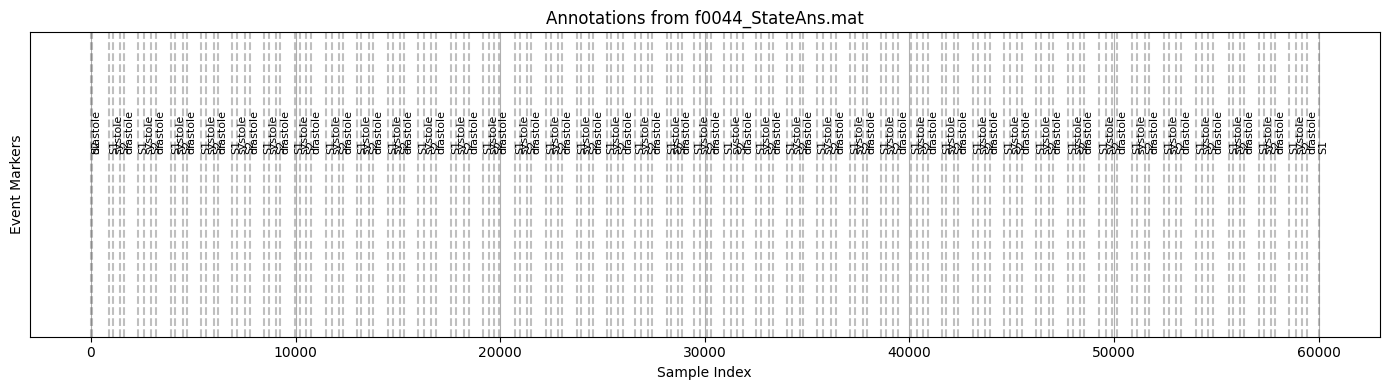


📂 File: f0001_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (168, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[519]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[759]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1559]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]]


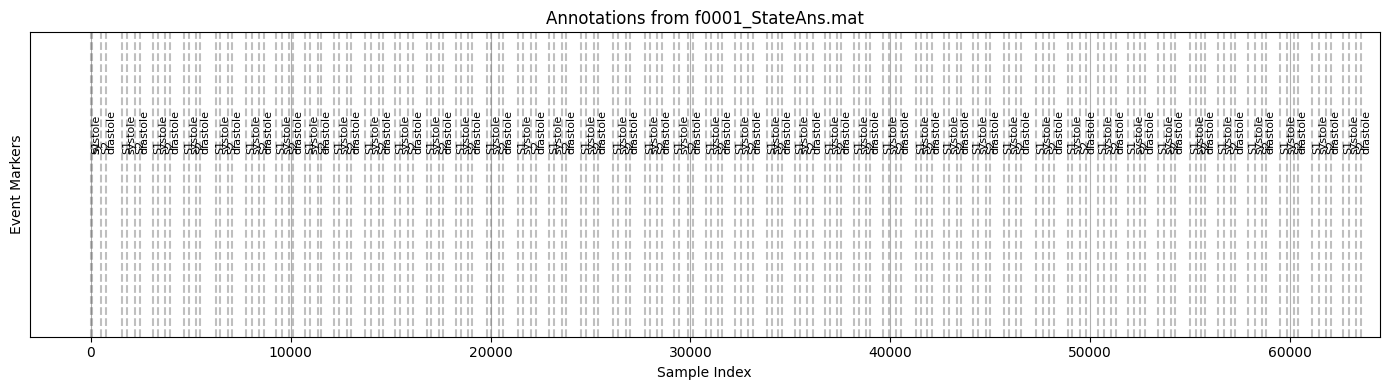


📂 File: f0114_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (114, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[799]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[999]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1479]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1719]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0114_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0042_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (164, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[399]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[639]], dtype=uint16)
  array(

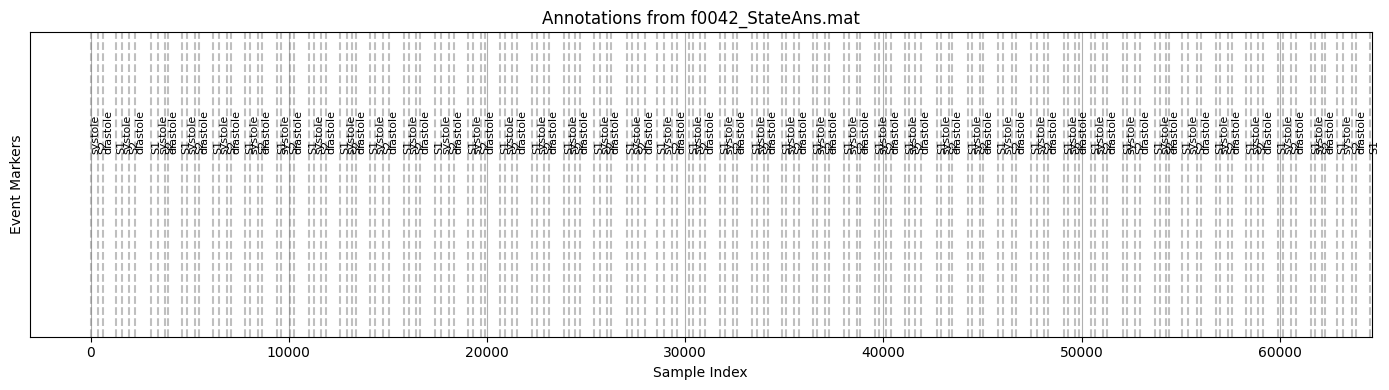


📂 File: f0016_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (191, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[399]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[639]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1079]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1359]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


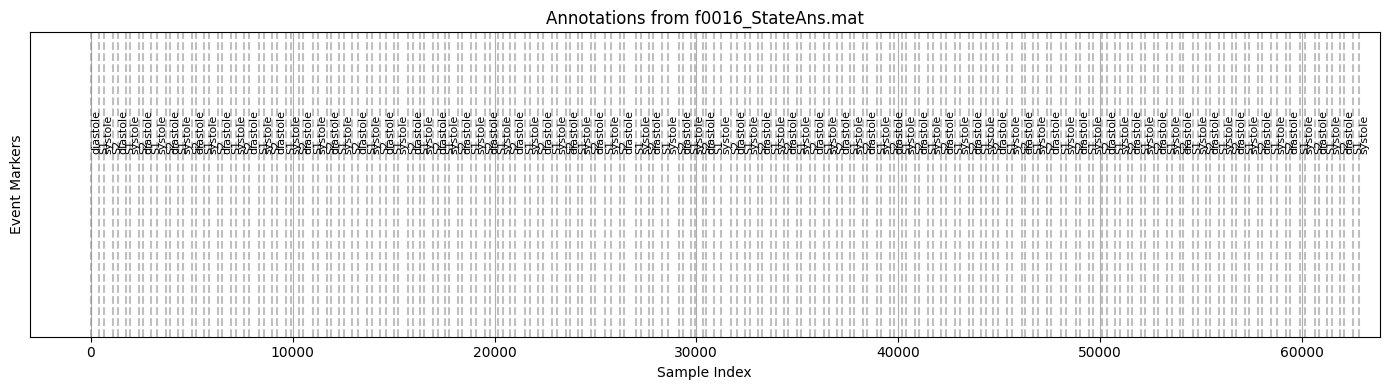


📂 File: f0038_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (157, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[559]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[839]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1359]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1599]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


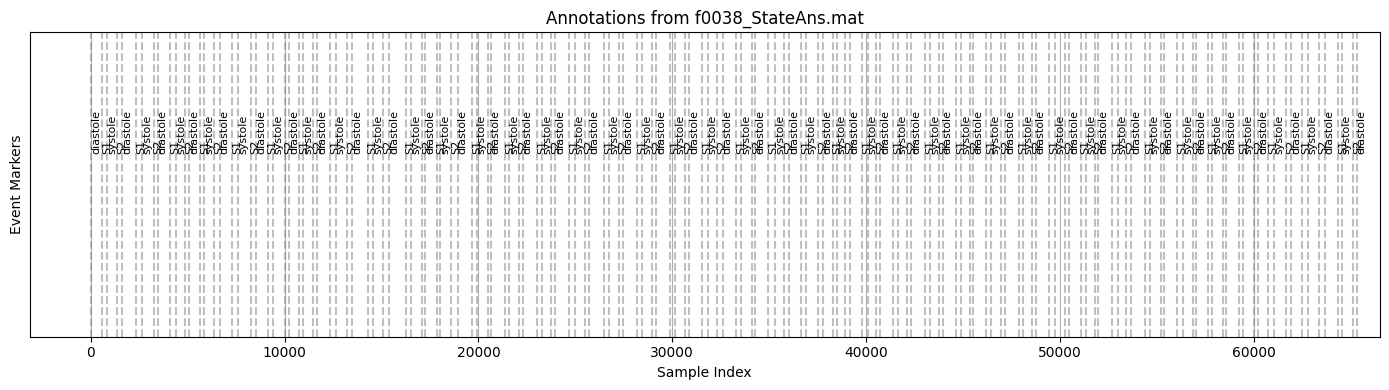


📂 File: f0007_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (100, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[20999]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[21719]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[21999]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[22319]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0007_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0087_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (137, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[359]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[639]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array

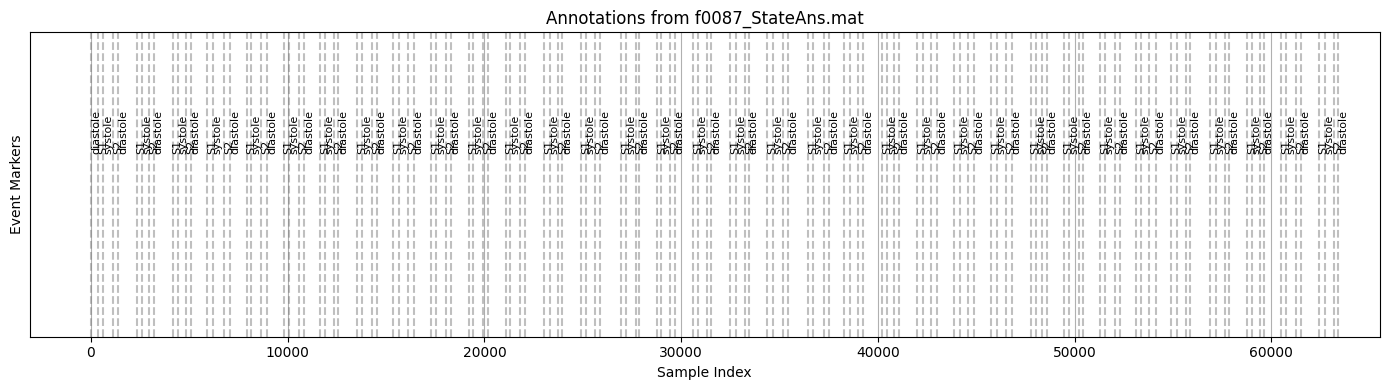


📂 File: f0020_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (152, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['systole'], dtype='<U7')]
 [array([[240]], dtype=uint8) array(['S2'], dtype='<U2')]
 [array([[372]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1403]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1654]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0020_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0113_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (70, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[3399]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[4679]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[4959]], dtype=uint16)
  array([[array(['systole'], dtype=

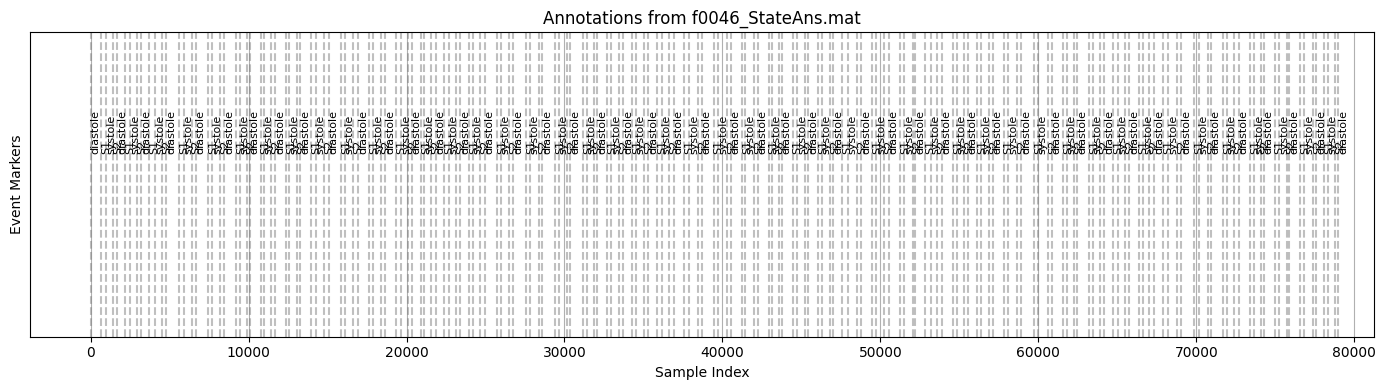


📂 File: f0105_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (225, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[359]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[679]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[799]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1079]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


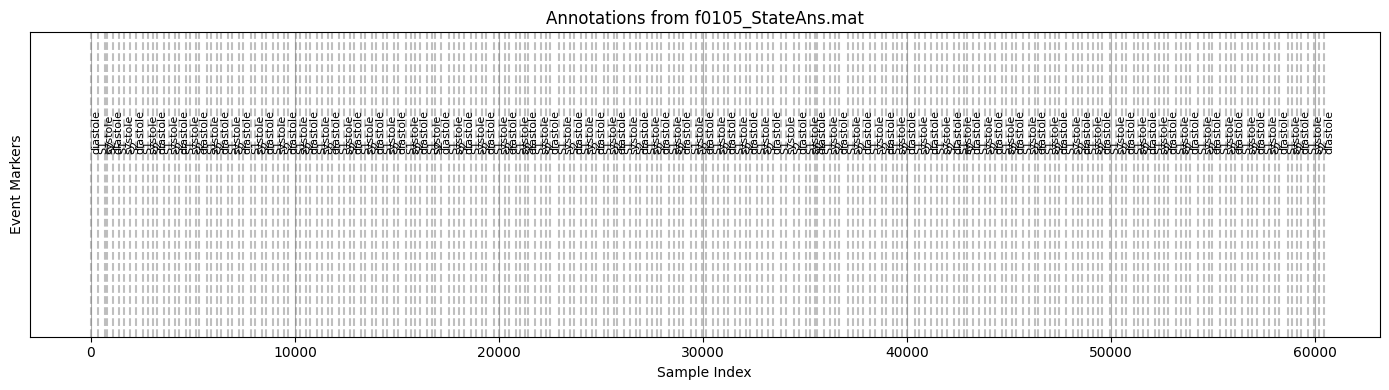


📂 File: f0053_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (149, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1039]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1279]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1679]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]


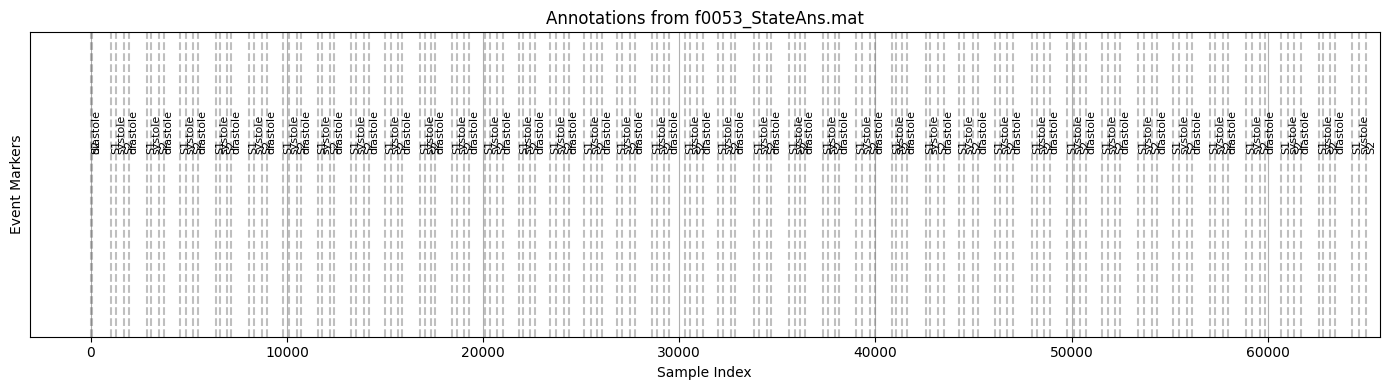


📂 File: f0039_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (154, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1119]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1479]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1879]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]


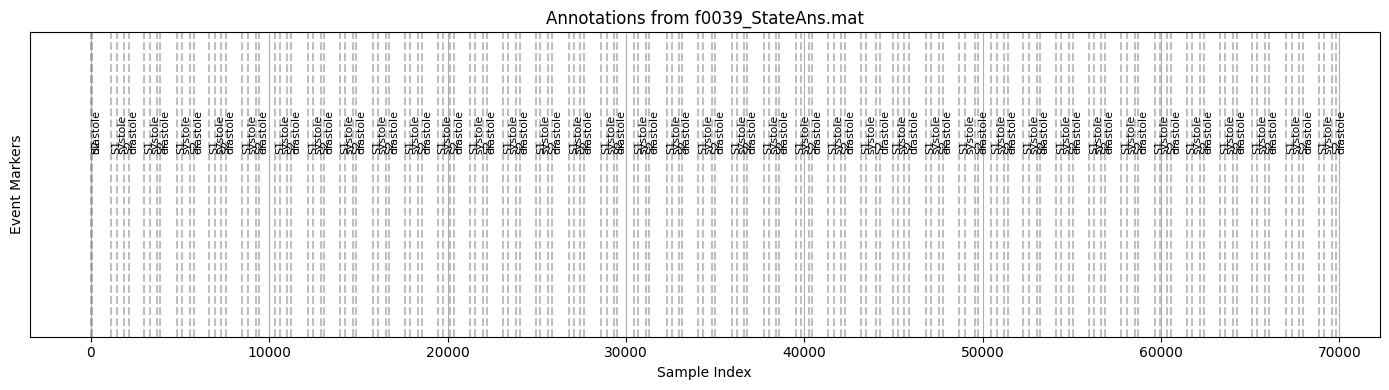


📂 File: f0096_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (123, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[479]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[639]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1879]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[2119]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


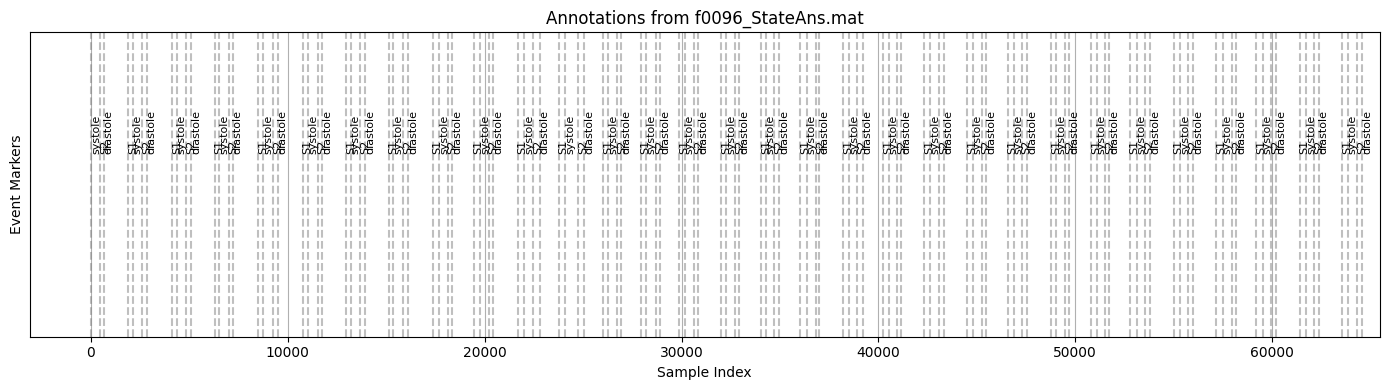


📂 File: f0064_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (111, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[10519]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[11359]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[11559]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[11919]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0064_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0005_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (148, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[2359]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[3439]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[3759]], dtype=uint16)
  array([[array(['systole'], dtype='<U

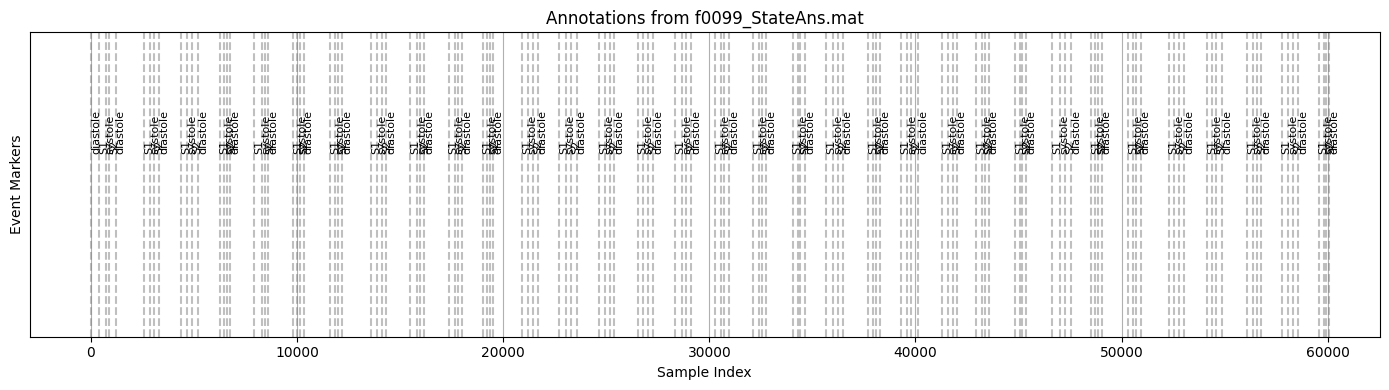


📂 File: f0101_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (150, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[279]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[519]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1119]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1399]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


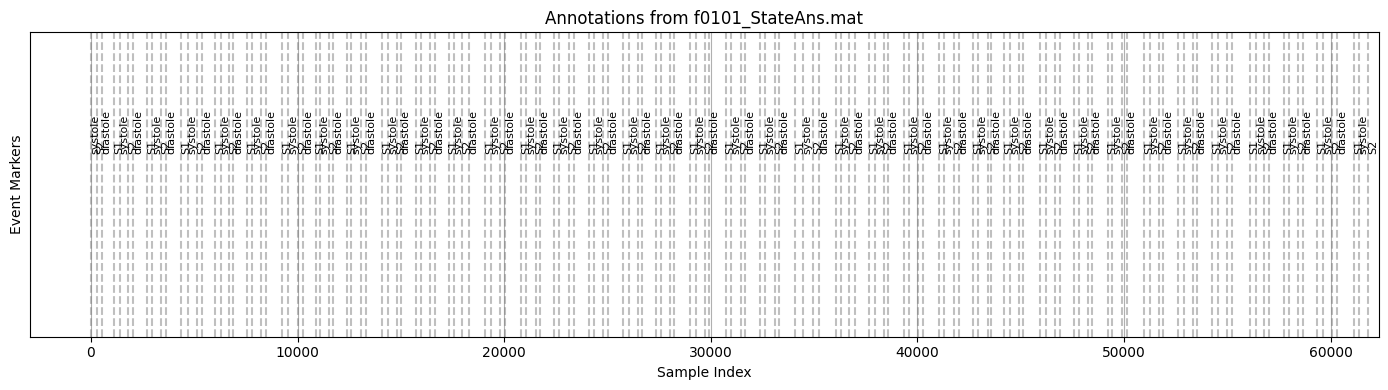


📂 File: f0045_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (139, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[479]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[719]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1759]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[2039]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0045_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0063_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (150, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[199]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[479]], dtype=uint16)
  array([

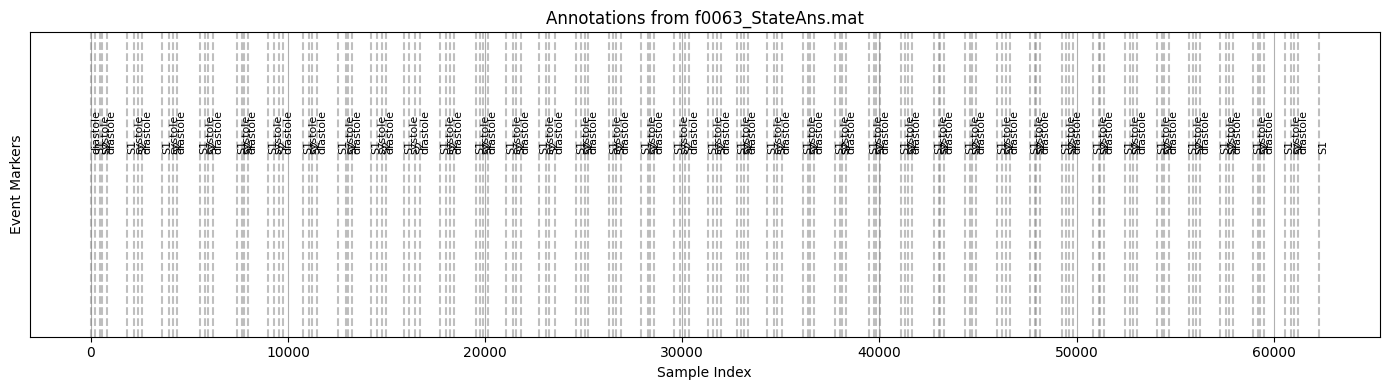


📂 File: f0058_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (2, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[81216]], dtype=int32) array(['N)'], dtype='<U2')]]
⚠️ Failed to plot 'state_ans' from f0058_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0033_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (172, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[159]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[359]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1079]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1319]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


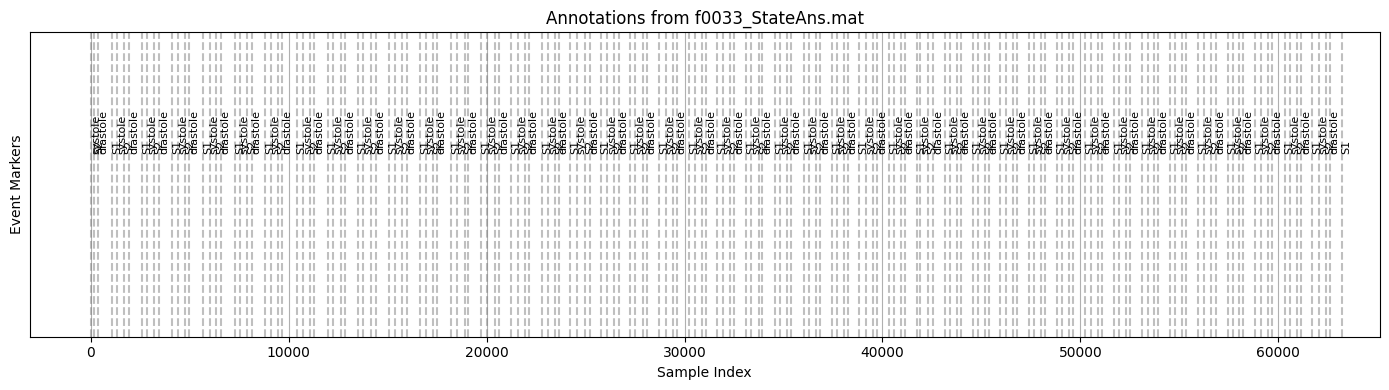


📂 File: f0061_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (149, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[397]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[675]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1163]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1427]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0061_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0037_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (150, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1079]], dtype=uint16)
  array(

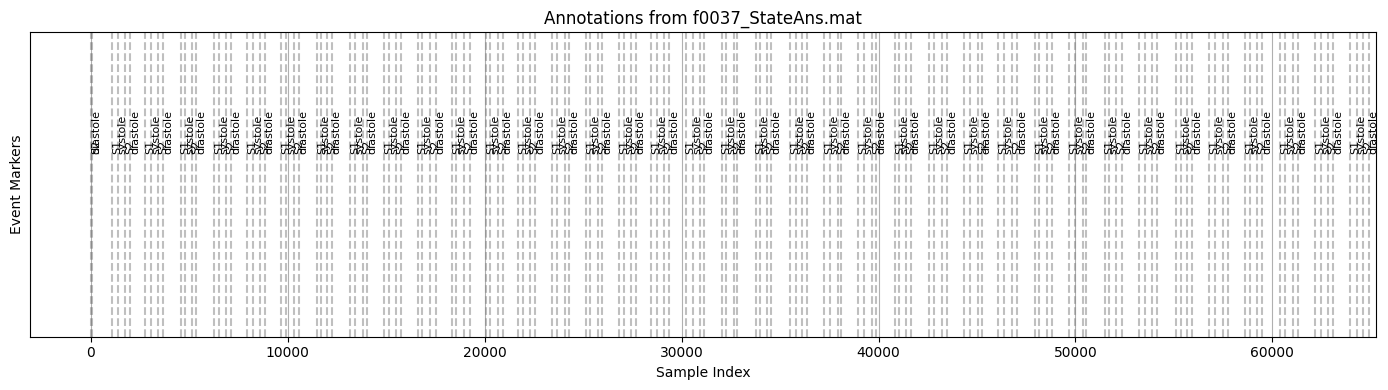


📂 File: f0048_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (159, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[399]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[679]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[1439]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[1799]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]]


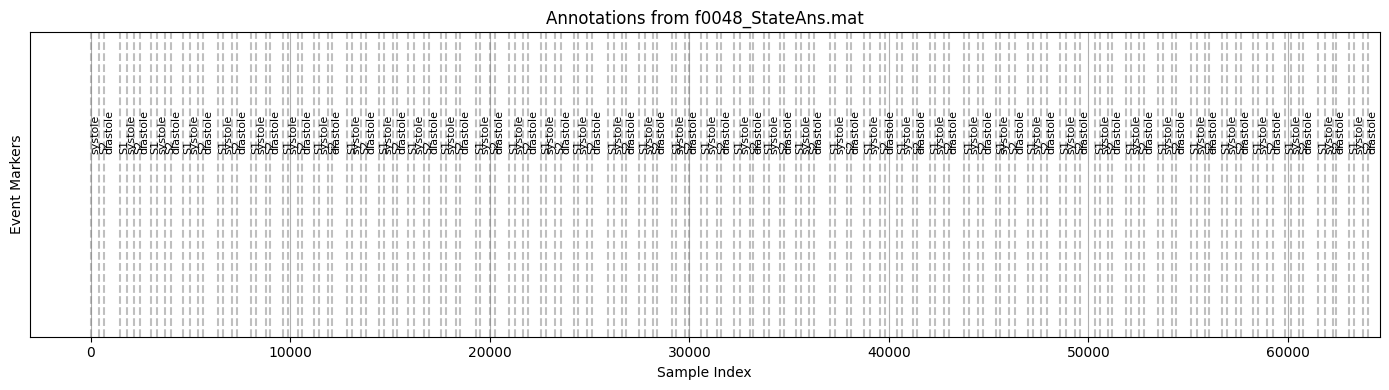


📂 File: f0024_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (145, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[639]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[839]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1439]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1639]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


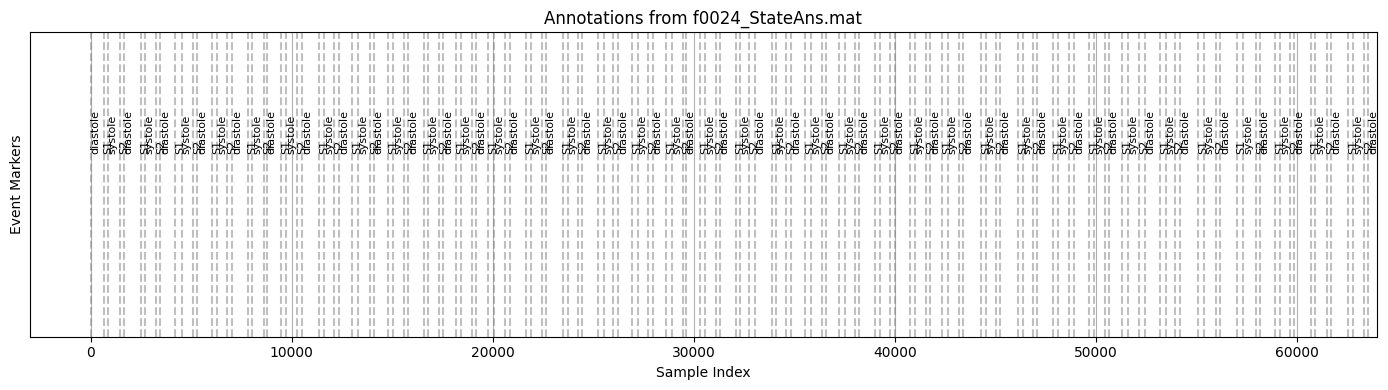


📂 File: f0095_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (252, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[559]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[919]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1519]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]


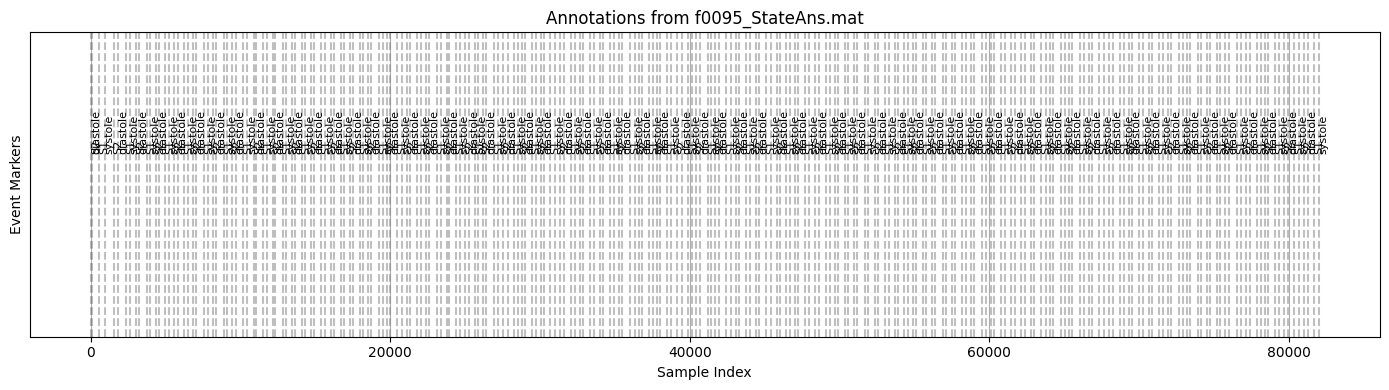


📂 File: f0027_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (121, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[199]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[559]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[879]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1119]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


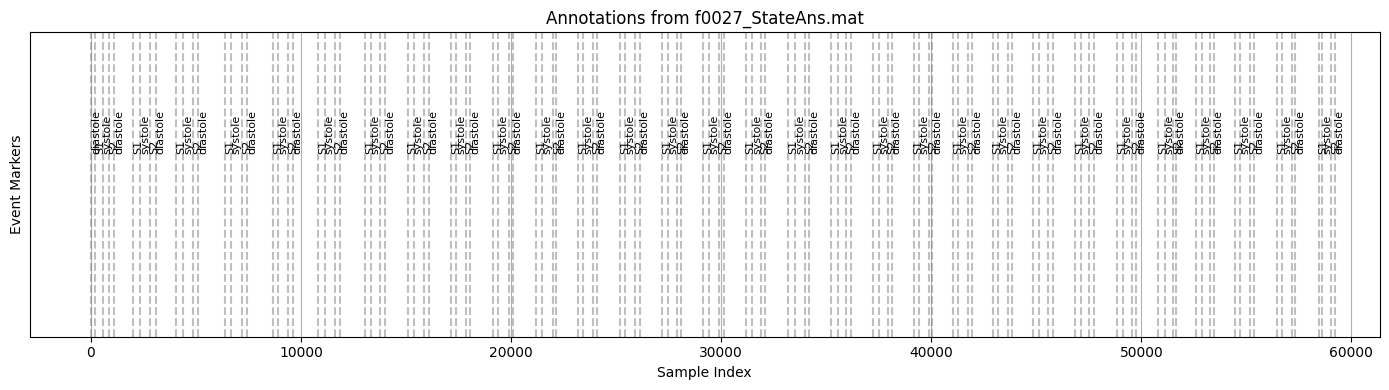


📂 File: f0008_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (265, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]
 [array([[439]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[759]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[1119]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[1399]], dtype=uint16)
  array([[array(['diastole'], dtype='<U8')]], dtype=object)]]


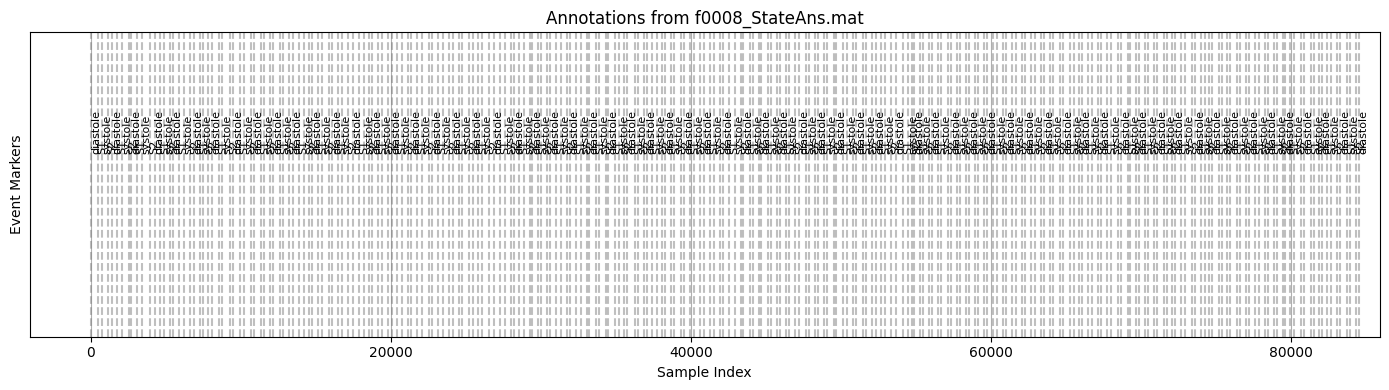


📂 File: f0103_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (31, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[16639]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[18199]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[18519]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[19079]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0103_StateAns.mat: 'str' object has no attribute 'item'

📂 File: f0028_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (160, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[39]], dtype=uint8)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[519]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]
 [array([[719]],

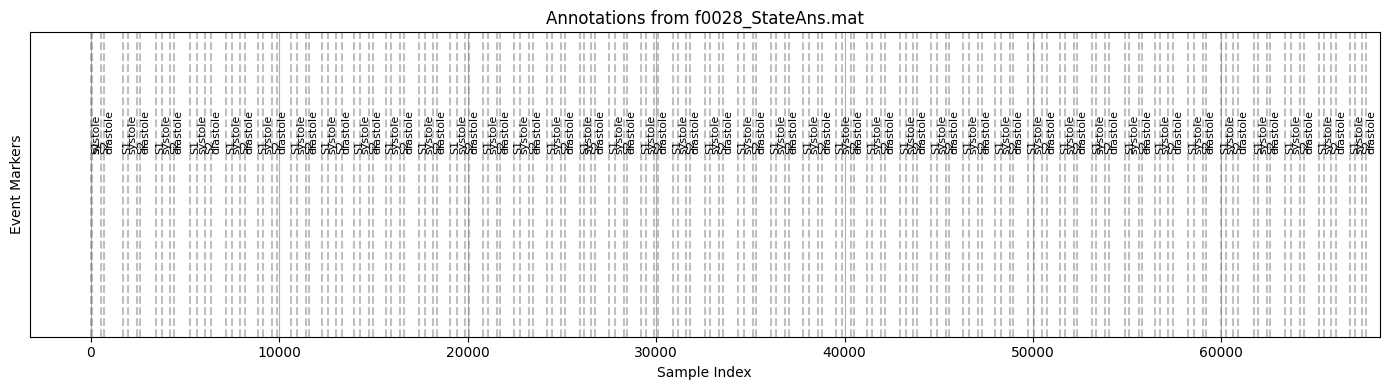


📂 File: f0075_StateAns.mat
🔑 Key: 'state_ans' | Type: <class 'numpy.ndarray'> | Shape: (124, 2)
   🔤 Sample (String-like): [[array([[1]], dtype=uint8) array(['(N'], dtype='<U2')]
 [array([[13359]], dtype=uint16) array(['N)'], dtype='<U2')]
 [array([[14079]], dtype=uint16)
  array([[array(['S1'], dtype='<U2')]], dtype=object)]
 [array([[14319]], dtype=uint16)
  array([[array(['systole'], dtype='<U7')]], dtype=object)]
 [array([[14799]], dtype=uint16)
  array([[array(['S2'], dtype='<U2')]], dtype=object)]]
⚠️ Failed to plot 'state_ans' from f0075_StateAns.mat: 'str' object has no attribute 'item'


In [59]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os

# === Path to your folder ===
mat_dir = "/home/psyche/Downloads/archive (2)"
mat_files = []

# === Collect the first 5 .mat files ===
for root, _, files in os.walk(mat_dir):
    for file in files:
        if file.endswith(".mat"):
            mat_files.append(os.path.join(root, file))
    if len(mat_files) >= 5:
        break

# === Inspect and plot state_ans if present ===
for mat_path in mat_files:
    print(f"\n📂 File: {os.path.basename(mat_path)}")
    mat_data = scipy.io.loadmat(mat_path)

    for key in mat_data:
        if key.startswith("__"):
            continue  # Skip MATLAB internals
        value = mat_data[key]
        print(f"🔑 Key: '{key}' | Type: {type(value)} | Shape: {np.shape(value)}")

        # Show sample content
        if isinstance(value, np.ndarray) and value.dtype.kind in {'i', 'f'}:
            print("   🔢 Sample Values:", value.ravel()[:10])
        elif isinstance(value, np.ndarray) and value.dtype.kind in {'U', 'S', 'O'}:
            print("   🔤 Sample (String-like):", value[:5])
        else:
            print("   📦 Skipped non-standard value preview.")

    # === Try plotting if 'state_ans' is present ===
    if "state_ans" in mat_data:
        try:
            state_ans = mat_data["state_ans"]

            # Flatten and extract index + label
            positions = []
            labels = []

            for row in state_ans:
                index = int(row[0].item())
                label = row[1].item().item()
                positions.append(index)
                labels.append(label)

            # === Plot
            plt.figure(figsize=(14, 4))
            for pos, label in zip(positions, labels):
                plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
                plt.text(pos, 1.02, label, rotation=90, verticalalignment='bottom', fontsize=8)

            plt.title(f"Annotations from {os.path.basename(mat_path)}")
            plt.xlabel("Sample Index")
            plt.ylabel("Event Markers")
            plt.ylim(0.9, 1.1)
            plt.yticks([])
            plt.tight_layout()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"⚠️ Failed to plot 'state_ans' from {os.path.basename(mat_path)}: {e}")


In [7]:
import wfdb
import matplotlib.pyplot as plt

# Example: record without extension
record_path = "/home/psyche/Downloads/archive (2)/normal/a0007"  # exclude .dat/.hea

# Load record and metadata
record = wfdb.rdrecord(record_path)
signal = record.e_d_signal  # shape: (samples, channels)

# Plot the signal
plt.figure(figsize=(14, 4))
plt.plot(signal[:, 0], label='Channel 1')  # plot first channel
plt.title(f"{record_path} - Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()


TypeError: 'NoneType' object is not subscriptable

<Figure size 1400x400 with 0 Axes>

📄 Record Info:
  - Record name: a0035
  - Sampling frequency: 2000
  - Duration (sec): 28.9825
  - Channels: ['PCG', 'ECG']
  - Units: ['mV', 'mV']
  - Comments: ['Normal']
  - Signal shape: (57965, 2)



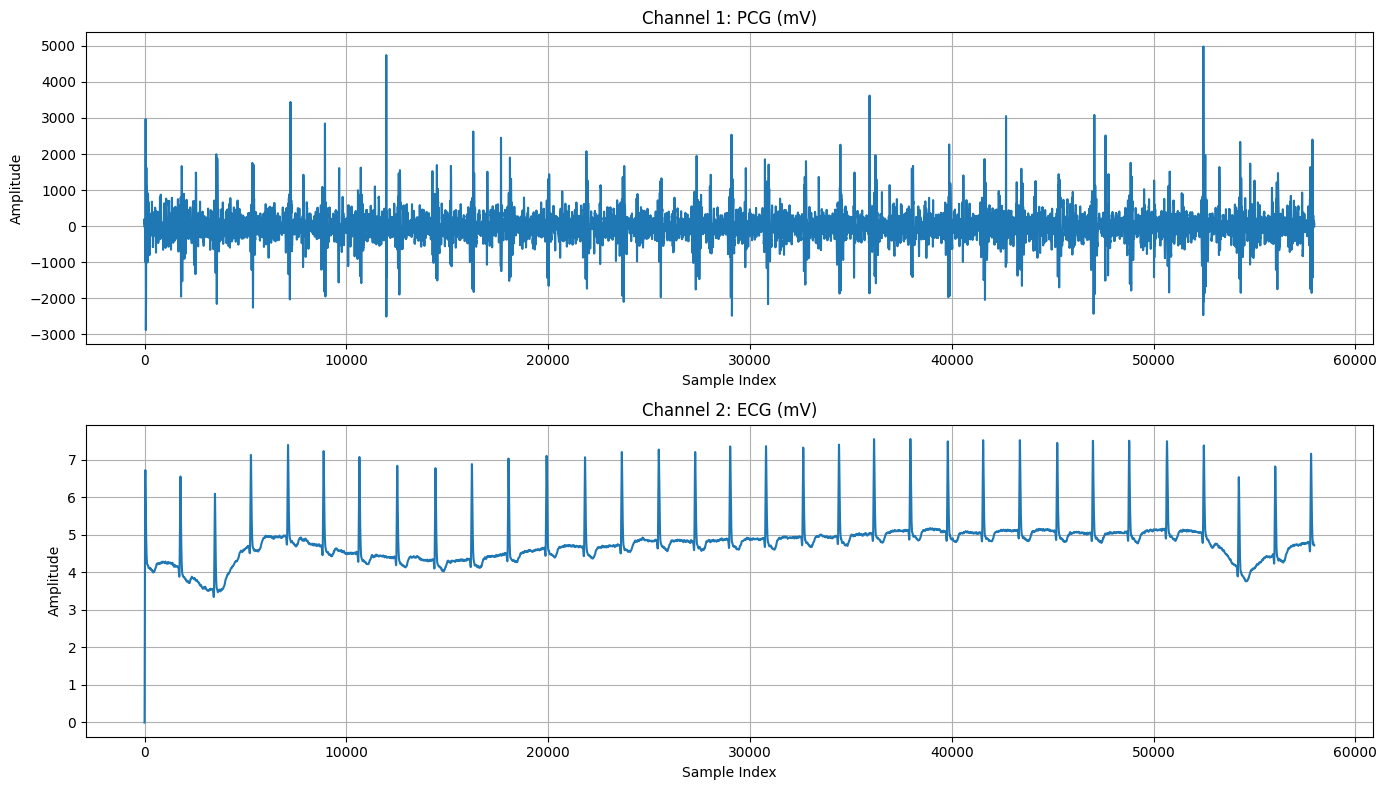

In [13]:
import wfdb
import matplotlib.pyplot as plt

# Load the record (exclude extension)
record_path = "/home/psyche/Downloads/archive (2)/normal/a0035"

# Load the .dat and .hea data
record = wfdb.rdrecord(record_path)

# Show available metadata
print("📄 Record Info:")
print("  - Record name:", record.record_name)
print("  - Sampling frequency:", record.fs)
print("  - Duration (sec):", len(record.p_signal) / record.fs)
print("  - Channels:", record.sig_name)
print("  - Units:", record.units)
print("  - Comments:", record.comments)
print("  - Signal shape:", record.p_signal.shape)
print("")

# Preview signal (you can access raw via record.d_signal)
signal = record.p_signal

# Plot all channels
plt.figure(figsize=(14, 4 * signal.shape[1]))
for i in range(signal.shape[1]):
    plt.subplot(signal.shape[1], 1, i+1)
    plt.plot(signal[:, i])
    plt.title(f"Channel {i+1}: {record.sig_name[i]} ({record.units[i]})")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
plt.tight_layout()
plt.show()
